# A Machine Learning Approach to Crypto Returns Forecasting Based on Exchange Net Flows

## Project outline

Starting from Bitcoin (BTC) and Ethereum (ETH) daily data from June 2016 to July
2021, we first analyze the data to determine the predictive power of exchange flows data and  then realize two deep learning-based models (MLPs) with the aim of predicting returns’ values and signs. In order to better understand the true contribution of the informational content
of exchange flows on our prediction results we also realize a feature contribution analysis on the obtained models.

The notebook is organized as follows:
* Part I: [Preliminary Analysis](#sec_analysis)
* Part II: [Regression model](#sec_regression)
* Part III: [Classification model](#sec_classification)

Note that the data cleaning and feature engineering part of this project is executed on a separate notebook, here we will limit to import the obtained data as csv files.

# Part I: Preliminary Analysis <a id='sec_analysis'></a>

An initial objective will be to verify that the causal relation between exchange flows from main crypto markets and price returns (for BTC and ETH) holds also for the dataset that we are going to use (which includes more recent data than previous studies on the topic, but daily instead of hourly).
* [Exploratory analysis](#sec_expl) of the dataset: summary statistics for each feature across exchanges and for both currencies, Jarque-Bera normality test and Augmented dickey Fuller stationarity test, correlation analysis (+ commentary on the results found)
* [Vector Autoregression](#sec_lin) analysis between features with different lags and across exchanges
* [Granger-causality](#sec_grang) between features and across exchanges

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Exploratory Analysis <a id='sec_expl'></a>

RET: daily log return <br>
VOL: daily trading volume <br>
NET: daily net flow (inflow minus outflow) <br>
9 exchanges: Binance, Bitfinex, Bitmex, Bitstamp, Bittrex, Huobi, Kraken, Kucoin, and Poloniex

In [2]:
## import raw data
btc_d = pd.read_csv('data/btc_daily_data.csv')
eth_d = pd.read_csv('data/eth_daily_data.csv')

In [3]:
## clean Bitcoin data 
exch = ['binance', 'bitfinex', 'bitmex', 'bitstamp', 'bittrex', 'gemini', 'huobi', 'kraken', 'poloniex']
btc = pd.DataFrame(index=btc_d['date']) 
# RET: daily return
btc['RET'] = np.log(btc_d['close']/btc_d['close'].shift(1)).tolist() # daily log return
# VOL: daily trading volume
btc['VOL'] = btc_d['volume'].tolist()
# NET: daily net flow
for exchange in exch:
    btc['NET.{}'.format(exchange)]=(btc_d['exch.{}.flow.in.ntv'.format(exchange)]-
                                    btc_d['exch.{}.flow.out.ntv'.format(exchange)]).tolist()

display(btc.head())

,RET,VOL,NET.binance,NET.bitfinex,NET.bitmex,NET.bitstamp,NET.bittrex,NET.gemini,NET.huobi,NET.kraken,NET.poloniex
date,,,,,,,,,,,
2016-06-30,NaN,148920.0,0.0,-2059.973067,99.331971,-2593.080092,-125.948094,206.048336,-2375.033630,2024.025567,-2778.125983
2016-07-01,0.006768,100240.0,0.0,4240.004996,92.550998,1251.658664,168.334678,-105.925147,-2268.096642,-928.878199,613.166590
2016-07-02,0.034230,177630.0,0.0,-3811.891401,-25.376020,-597.836889,9.495110,-44.394717,-9159.634110,672.465411,-1075.431292
2016-07-03,-0.053583,65100.0,0.0,5237.602833,-2.565174,647.374927,88.733722,402.367398,-9530.151435,-416.704041,23.876708
2016-07-04,0.020228,67140.0,0.0,288.595371,-22.923171,545.125563,145.272407,185.619464,3390.126196,3161.476927,679.750955


In [4]:
## clean Ethereum data
exch = ['binance', 'bitfinex', 'bitstamp', 'bittrex', 'gemini', 'kraken', 'poloniex'] # no ETH data for bitmex and huobi
eth = pd.DataFrame(index=eth_d['date']) 
eth['RET'] = np.log(eth_d['close']/eth_d['close'].shift(1)).tolist() # daily log return
eth['VOL'] = eth_d['volume'].tolist()
for exchange in exch:
    eth['NET.{}'.format(exchange)]=(eth_d['exch.{}.flow.in.ntv'.format(exchange)]-
                                    eth_d['exch.{}.flow.out.ntv'.format(exchange)]).tolist()
display(eth.head())

,RET,VOL,NET.binance,NET.bitfinex,NET.bitstamp,NET.bittrex,NET.gemini,NET.kraken,NET.poloniex
date,,,,,,,,,
2016-06-30,NaN,968940.0,0.0,4357.847025,0.0,4745.345643,9718.900192,34368.279174,31486.711303
2016-07-01,-0.008903,1250000.0,0.0,420.873548,0.0,5347.637741,-4673.071735,17816.258406,5347.576758
2016-07-02,-0.015568,1890000.0,0.0,23169.410924,0.0,3684.385453,-2414.242300,-7351.123703,11283.902563
2016-07-03,-0.031030,786940.0,0.0,-7909.724666,0.0,-3312.355331,-7902.002866,-3797.682825,11648.982746
2016-07-04,-0.031144,907110.0,0.0,1271.289529,0.0,1014.503037,590.383059,398444.262380,63597.078794


In [5]:
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller

def stylizedfacts(ts):
    ts = ts.dropna() 
    ts = ts[ts != 0]
    Mean = ts.mean()
    Std = ts.std()
    Min = ts.min()
    Median = ts.median()
    Max = ts.max()
    JB = round(jarque_bera(ts).statistic,4)
    JB_pval = jarque_bera(ts).pvalue
    if JB_pval <= 0.01:
        JB = f'{JB}***'
    elif 0.01 < JB_pval <= 0.05:
        JB = f'{JB}**'
    elif 0.05 < JB_pval <= 0.1:
        JB = f'{JB}*'
    adf = round(adfuller(ts)[0],4)
    adf_pval = adfuller(ts)[1]
    if adf_pval <= 0.01:
        adf = f'{adf}***'
    elif 0.01 < adf_pval <= 0.05:
        adf = f'{adf}**'
    elif 0.05 < adf_pval <= 0.1:
        adf = f'{adf}*'
    output = pd.Series([Mean, Std, Min, Median, Max, JB, adf])
    return output

In [6]:
multindex = [
    np.array(["BTC"]*btc.shape[1] + ["ETH"]*eth.shape[1]),
    np.array(btc.columns.tolist() + eth.columns.tolist()),
]
stat = pd.DataFrame(index=multindex, columns=['Mean', 'Std', 'Min', 'Median', 'Max', 'JB', 'ADF']) 

for col in btc.columns:
    stat.loc[('BTC',col)] = stylizedfacts(btc[col]).tolist()
    
for col in eth.columns:
    stat.loc[('ETH',col)] = stylizedfacts(eth[col]).tolist()

display(stat)

Mean             Std             Min       Median  \
BTC RET                 0.002207        0.042019       -0.479934      0.00218   
    VOL            585677.256065  1397859.647552          2400.0     180670.0   
    NET.binance       277.129008     2865.642278   -27245.169933   135.719422   
    NET.bitfinex     -130.496513     6108.728426  -121054.090457    30.834436   
    NET.bitmex         56.213694      1889.04744   -34096.929705    51.858614   
    NET.bitstamp     -262.611975     2172.255358   -30531.728449  -153.417498   
    NET.bittrex       -64.889362     1575.058929   -11265.461988   -59.163814   
    NET.gemini         53.241906     2112.491507   -16424.057375    19.786539   
    NET.huobi         -38.455199     2516.984113   -26518.490634     40.50666   
    NET.kraken       -281.191593     3092.109855   -40168.725188  -100.529798   
    NET.poloniex      -48.731764     1754.121295   -19364.006567    -57.99326   
ETH RET                 0.002826        0.057639       -0.569507     0.000926   
    VOL           6039636.555256  8103349.085864          7610.0    2280000.0   
    NET.binance      2499.962054    51968.802486   -539884.30289   141.228885   
    NET.bitfinex     -315.998976    70364.866534  -995304.971652   376.732092   
    NET.bitstamp      414.195889    12537.012075  -201171.103685   239.789587   
    NET.bittrex       431.825197    10825.815083  -163193.049145    -253.2652   
    NET.gemini        547.595656    25297.449481  -231237.108676   -61.136853   
    NET.kraken      -2992.271849    35873.495218  -744418.305422 -2417.488645   
    NET.poloniex     -4075.30423    76326.130267 -1224401.233088 -1238.442795   

                             Max               JB          ADF  
BTC RET                 0.227618    11056.5197***  -29.7557***  
    VOL               20260000.0   302236.4974***   -7.7187***  
    NET.binance     26273.320001    28389.4954***   -8.0798***  
    NET.bitfinex     32536.40393   4188060.707***  -12.8943***  
    NET.bitmex      25151.010367   657443.9981***  -13.0256***  
    NET.bitstamp    14668.299449    154786.592***  -43.0446***  
    NET.bittrex     19345.994173    49811.1038***   -6.6744***  
    NET.gemini      32811.067196   180307.8894***   -7.7879***  
    NET.huobi       25256.626211    40711.2751***  -13.1328***  
    NET.kraken      38112.388789   201193.5622***  -10.2889***  
    NET.poloniex    13766.676194    31866.4199***   -8.9558***  
ETH RET                 0.260244     5242.9865***   -12.549***  
    VOL               77470000.0    12832.7224***    -3.2237**  
    NET.binance    424515.823542    53119.7266***  -16.9306***  
    NET.bitfinex   575011.437727   288043.0355***  -14.5602***  
    NET.bitstamp    80055.821536     265372.44***  -10.1146***  
    NET.bittrex     94608.848902   162973.1712***  -10.8251***  
    NET.gemini     285607.359589    99628.6224***   -8.2742***  
    NET.kraken      398444.26238  1205400.7237***   -6.5289***  
    NET.poloniex  1553929.089877  2169588.5531***  -13.7698***

The symbols \*, \*\*, and \*\*\* denote the rejection of the null hypothesis (normal and unit root/non-stationary) at the 10%, 5%, and 1% significance levels.

In [ ]:
print(stat.to_latex(index=True))  

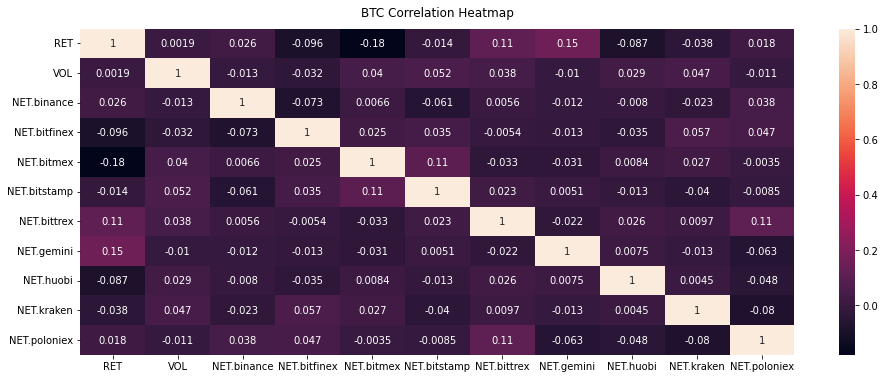

In [7]:
plt.figure(figsize=(16, 6))
btc_corr = sns.heatmap(btc[(btc!=0).all(1)].dropna().corr(), annot=True).set_title('BTC Correlation Heatmap', 
                                                                                    fontdict={'fontsize':12}, pad=12)
plt.show()

In [ ]:
btc_corr.figure.savefig("btc_corr.png")

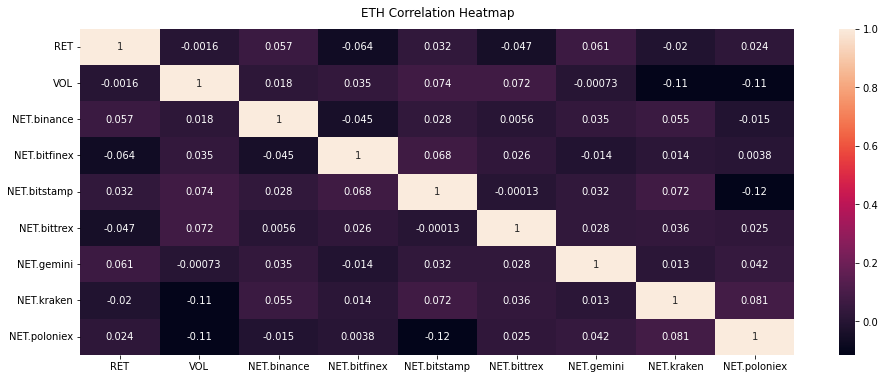

In [8]:
plt.figure(figsize=(16, 6))
eth_corr = sns.heatmap(eth[(eth!=0).all(1)].dropna().corr(), annot=True).set_title('ETH Correlation Heatmap', 
                                                                                    fontdict={'fontsize':12}, pad=12)
plt.show()

In [ ]:
eth_corr.figure.savefig("eth_corr.png")

## 2. Vector Autoregression (VAR) <a id='sec_lin'></a>

VAR between return and net flow among the exchanges <br>

$$ \text{VAR(3):  } Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \phi_3 Y_{t-3} + \epsilon_t $$
L1 - one lag 

In [9]:
from statsmodels.tsa.api import VAR

In [10]:
btc_data = btc[(btc!=0).all(1)].dropna()
model = VAR(btc_data)
results = model.fit(3) # order: 3 lags
param = round(results.params,4)
pval = results.pvalues

/Users/wexu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [11]:
btc_VAR_res = pd.DataFrame(index=param.index, columns=param.columns)
for col in param.columns:
    for row in param.index:
        if pval[col].loc[row] <= 0.01:
            btc_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}***'
        elif 0.01 < pval[col].loc[row] <= 0.05:
            btc_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}**'
        elif 0.05 < pval[col].loc[row] <= 0.1:
            btc_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}*'
        else:
            btc_VAR_res[col].loc[row] = param[col].loc[row]
btc_VAR_res = btc_VAR_res.drop(index='const')
display(btc_VAR_res)

,RET,VOL,NET.binance,NET.bitfinex,NET.bitmex,NET.bitstamp,NET.bittrex,NET.gemini,NET.huobi,NET.kraken,NET.poloniex
L1.RET,-0.0618**,-51755.2589,3264.9283*,-5007.5883**,-141.9644,1598.0887,-1827.4775*,4295.6048***,2739.6826**,-1128.7883,-276.8568
L1.VOL,0.0,0.6397***,0.0001,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
L1.NET.binance,-0.0,-3.5123,0.0714***,-0.0389,-0.028,-0.0138,0.0209,0.0039,0.04*,-0.0094,0.018
L1.NET.bitfinex,-0.0,-1.7189,0.0211,0.0659**,0.0566***,0.0088,0.0333***,0.012,0.006,0.0243,0.0248***
L1.NET.bitmex,0.0,2.1987,0.016,0.051,0.2018***,0.0629**,0.0096,0.0626**,-0.0465,-0.0078,-0.0074
L1.NET.bitstamp,-0.0,0.2492,-0.0013,-0.0085,0.0346,0.0299,-0.0361*,0.0313,0.0446*,-0.177***,0.0084
L1.NET.bittrex,0.0,-0.2166,0.1187***,-0.0244,-0.0477,-0.0084,0.2036***,-0.0226,-0.0716**,0.0374,0.0143
L1.NET.gemini,-0.0**,-0.6369,-0.0107,-0.0362,0.0269,0.0045,-0.0314,-0.0027,0.0386,0.0485,0.0181
L1.NET.huobi,-0.0*,3.8141,-0.0171,0.0353,-0.0061,0.0217,0.0215,0.004,0.2448***,0.0813**,-0.0186
L1.NET.kraken,-0.0,3.9274,-0.0057,0.0092,-0.0278,-0.0536***,0.0008,-0.0339*,0.054***,0.1248***,0.0396***


The symbols \*, \*\*, and \*\*\* denote the statistical significance at the 10%, 5%, and 1% levels

In [ ]:
print(btc_VAR_res.to_latex(index=True))  

In [12]:
eth_data = eth[(eth!=0).all(1)].dropna()
model = VAR(eth_data)
results = model.fit(3) # order: 3 lags
param = round(results.params,4)
pval = results.pvalues

/Users/wexu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [13]:
eth_VAR_res = pd.DataFrame(index=param.index, columns=param.columns)
for col in param.columns:
    for row in param.index:
        if pval[col].loc[row] <= 0.01:
            eth_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}***'
        elif 0.01 < pval[col].loc[row] <= 0.05:
            eth_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}**'
        elif 0.05 < pval[col].loc[row] <= 0.1:
            eth_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}*'
        else:
            eth_VAR_res[col].loc[row] = param[col].loc[row]
eth_VAR_res = eth_VAR_res.drop(index='const')
display(eth_VAR_res)

,RET,VOL,NET.binance,NET.bitfinex,NET.bitstamp,NET.bittrex,NET.gemini,NET.kraken,NET.poloniex
L1.RET,-0.0727***,597518.3399,46938.9583*,-93761.4177***,6205.8914,-4560.0646,19127.78*,-12505.9957*,-12221.8822**
L1.VOL,-0.0,0.799***,0.0003,0.0003,0.0,0.0002***,0.0,-0.0,-0.0
L1.NET.binance,-0.0,1.8787,-0.0601**,-0.0255,0.0115*,0.0024,0.0022,-0.0002,-0.009*
L1.NET.bitfinex,0.0**,1.4307,-0.0086,0.1786***,0.0049,-0.0074,-0.0142,0.004,-0.0037
L1.NET.bitstamp,0.0,0.1534,0.1151,-0.0075,-0.0388,-0.0003,0.056,-0.0109,0.0809***
L1.NET.bittrex,-0.0,10.3739,0.213*,-0.0318,-0.0186,0.2241***,-0.014,0.0097,-0.0427*
L1.NET.gemini,-0.0,-1.4211,-0.0383,-0.0434,-0.0083,-0.0154,-0.0317,0.0335*,0.0096
L1.NET.kraken,-0.0,-6.0707,0.095,-0.0744,0.0524**,0.0246,0.0223,0.1762***,0.0635***
L1.NET.poloniex,0.0,7.6378,0.0323,-0.1913,0.0282,-0.0178,-0.0599,0.1156***,0.0439*
L2.RET,0.0911***,-2240694.4451,-87.0269,-34968.6041,3664.5715,-6185.0609,23059.6114**,-7567.3849,-10823.6172**


In [ ]:
print(eth_VAR_res.to_latex(index=True))  

## 3. Granger’s Causality <a id='sec_grang'></a>

1. return and net flow
2. return and volume

In [14]:
from statsmodels.tsa.stattools import grangercausalitytests

**null hypothesis: Granger non causality** (time series in the second column does NOT Granger cause the time series in the first column) <br>
4 tests: params_ftest, ssr_ftest (based on F distribution); ssr_chi2test, lrtest (based on chi-square distribution)

In [15]:
def grangers_causality_pval(data,lag):
    res = pd.DataFrame(index=data.columns, columns=data.columns)
    test_list = ['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest']
    for col in res.columns:
        for row in res.index:
            result = grangercausalitytests(data[[col, row]], # whether row variable granger cause column variable
                                         maxlag=lag, verbose=False) 
            # result[lag][0-summary][test][0-statistics,1-pval,2-DOF]
            minpval = np.min([np.min([round(result[i+1][0][test][1],6) for i in range(lag)]) # min pval of each test
                              for test in test_list]) # min pvalue of all test
            if minpval <= 0.01:
                res.loc[row,col] = f'{minpval}***' 
            elif 0.01 < minpval <= 0.05:
                res.loc[row,col] = f'{minpval}**' 
            elif 0.05 < minpval <= 0.1:
                res.loc[row,col] = f'{minpval}*' 
            else:
                res.loc[row,col] = minpval
            if row == col:
                res.loc[row,col] = '-'
    return res

In [16]:
btc_GC_res = grangers_causality_pval(btc_data,3)
display(btc_GC_res)

,RET,VOL,NET.binance,NET.bitfinex,NET.bitmex,NET.bitstamp,NET.bittrex,NET.gemini,NET.huobi,NET.kraken,NET.poloniex
RET,-,0.885425,0.043523**,0.001891***,0.645069,0.447772,0.003122***,0.0***,0.017457**,0.305457,0.139251
VOL,0.738179,-,0.645405,0.338368,0.145338,0.033997**,0.086896*,0.782383,0.363928,0.085273*,0.745888
NET.binance,0.373462,0.555179,-,0.116155,0.070047*,0.571515,0.246298,0.499973,0.172033,0.770107,0.14078
NET.bitfinex,0.099248*,0.387973,0.398871,-,8.5e-05***,0.585352,0.000682***,0.979828,0.799817,0.254785,0.00297***
NET.bitmex,0.534624,0.53498,0.936784,0.071771*,-,0.020908**,0.248235,0.034754**,0.095157*,0.790159,0.522236
NET.bitstamp,0.186612,0.029227**,0.939082,0.61908,0.064108*,-,0.118516,0.067819*,0.154341,0.0***,0.0***
NET.bittrex,0.141204,0.331912,0.004263***,0.073674*,0.106123,0.121934,-,0.206901,0.145839,0.223875,0.04394**
NET.gemini,0.009633***,0.830684,0.149061,0.114942,0.294047,0.889751,0.027772**,-,0.03643**,0.052492*,0.188848
NET.huobi,0.044543**,0.49495,0.468233,0.224634,0.712853,0.203409,0.043003**,0.876665,-,0.00375***,0.080484*
NET.kraken,0.807767,0.418185,0.724765,0.24155,0.211088,0.000136***,0.432591,0.002643***,0.002305***,-,0.0***


Note: the asterisk sign shows the row variable Granger cause the column variable (dependent variable). <br> \*, \*\*, and \*\*\* denote significance at the 10%, 5%, and 1% levels respectively.

In [ ]:
print(btc_GC_res.to_latex(index=True))  

In [17]:
eth_GC_res = grangers_causality_pval(eth_data,3)
display(eth_GC_res)

,RET,VOL,NET.binance,NET.bitfinex,NET.bitstamp,NET.bittrex,NET.gemini,NET.kraken,NET.poloniex
RET,-,0.288862,0.045691**,0.001059***,0.143768,0.521374,0.008306***,0.088575*,0.001298***
VOL,0.935213,-,0.655863,0.298275,0.007916***,0.007483***,0.888719,0.000605***,0.000119***
NET.binance,0.029882**,0.573791,-,0.156164,0.030625**,0.511574,0.217844,0.822465,0.112244
NET.bitfinex,0.05643*,0.30204,0.166462,-,0.001244***,0.07019*,0.044005**,0.026044**,0.725011
NET.bitstamp,0.003574***,0.23339,0.039855**,0.015595**,-,0.001806***,0.075816*,0.297341,3.4e-05***
NET.bittrex,0.560097,0.313586,0.085321*,0.30527,0.153731,-,0.629702,0.616164,0.025474**
NET.gemini,0.058853*,0.738486,0.311167,0.265245,0.500695,0.207928,-,0.065767*,0.720487
NET.kraken,0.047222**,0.119316,0.401056,0.222202,0.001114***,0.355309,0.460407,-,1e-06***
NET.poloniex,0.46369,0.447621,0.753802,0.417841,0.537024,0.342321,0.120426,0.000264***,-


In [ ]:
print(eth_GC_res.to_latex(index=True))  

# Part II: Regression model <a id='sec_regression'></a>

The goal of this part is to develop a MLP model to forecast BTC and ETH returns, tune it, train it and test in comparison to a benchmark model (Linear regression).

This part it structured as follows:
* [BTC model](#sec_BTCreg) 
* [ETH model](#sec_ETHreg) 

We start by importing the needed libraries and the engineered data for both BTC and ETH.

The imported data presents the following features:
* 'exchange_name.NET': daily net flows for a given exchange normalised by the corrisponding exchange supply
* 'close': close-close daily return
* 'high': close-high daily return
* 'low': close-low daily return
* 'high-low': high-low spread
* 'volume': daily trading volume
* 'weekly_vol': rolling 5-day average daily volatility estimate (computed from hourly prices)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from tensorflow import keras as k
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras.backend import get_session
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tscv import GapKFold
import keras_tuner as kt
import shap

In [2]:
btc_data = pd.read_csv(r'C:\Users\Riccardo\Desktop\EPFL\MA3\Machine Learning for Finance\Final project\data\btc_daily_data_NET_vol.csv')
btc_data.index = btc_data['date']
btc_data = btc_data.drop(['date', 'Unnamed: 0'], 1)
eth_data = pd.read_csv(r'C:\Users\Riccardo\Desktop\EPFL\MA3\Machine Learning for Finance\Final project\data\eth_daily_data_NET_vol.csv')
eth_data.index = eth_data['date']
eth_data = eth_data.drop(['date', 'Unnamed: 0'], 1)

btc_data.head()

,binance.NET,bitfinex.NET,bitmex.NET,bitstamp.NET,bittrex.NET,gemini.NET,huobi.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume,weekly_vol
date,,,,,,,,,,,,,,,
2016-07-04,0.0,0.001660,-0.003988,0.003470,0.011064,0.005198,0.024649,0.022781,0.007431,675.16,679.03,644.04,34.99,67140.0,7.773625
2016-07-05,0.0,-0.011358,-0.046352,-0.005179,-0.000648,-0.001491,0.030021,-0.003803,0.030980,663.67,679.19,657.31,21.88,66150.0,7.634982
2016-07-06,0.0,0.000691,-0.015311,0.005517,0.007162,-0.002760,0.078390,-0.010756,-0.013494,672.70,678.39,662.24,16.15,64870.0,9.708395
2016-07-07,0.0,0.013277,-0.115734,-0.007600,-0.002311,-0.038045,-0.025930,0.000635,-0.008824,635.25,676.19,604.95,71.24,118340.0,8.003366
2016-07-08,0.0,0.111602,-0.017591,-0.005359,0.021593,0.008810,0.029312,0.007042,0.002646,662.78,663.43,630.17,33.26,97460.0,8.281091


In [3]:
def split_dataset(dataset, prices, n_steps, train_percentage=0.8, input_scaler=None, output_scaler=None):
    ## 'dataset' and 'prices' are arrays
    # Splits a multivariate dataset ('dataset') into samples of size 'n_steps', 
    # flattens the resulting input samples and associates the corresponding output from 'prices',
    # divides the dataset in train and test data using 'train_percentage',
    # if 'input_scaler' and 'output_scaler' are not None: 
    # scales the resulting train and test data base on the train data statistics
    
    X, y = list(), list()
    for i in range(len(dataset)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix >= len(dataset):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = dataset[i:end_ix, :], prices[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    X, y = np.array(X), np.array(y)
    # flatten input
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    #divide in train and test data
    n = X.shape[0]
    ix = int(n*train_percentage)
    X_train = X[:ix, :]
    X_test = X[ix+n_steps:, :]
    y_train = y[:ix]
    y_test = y[ix+n_steps:]

    ## scale inputs
    if input_scaler is not None:
        input_scaler.fit(X_train)
        X_train = input_scaler.transform(X_train)
        X_test = input_scaler.transform(X_test)
    ## scale outputs
    if output_scaler is not None:
        # reshape 1d arrays to 2d arrays
        y_train = y_train.reshape(len(y_train), 1)
        y_test = y_test.reshape(len(y_test), 1)
        output_scaler.fit(y_train)
        y_train = output_scaler.transform(y_train)
        y_test = output_scaler.transform(y_test)

    return X_train, X_test, y_train, y_test


## BTC model <a id='sec_BTCreg'></a>

In [4]:
#compute returns 
log_ret = np.log(btc_data['close'].values[1:] / btc_data['close'].values[:-1])
log_ret_high = np.log(btc_data['high'].values[1:] / btc_data['close'].values[:-1])
log_ret_low = np.log(btc_data['low'].values[1:] / btc_data['close'].values[:-1])

btc_data_ret = pd.DataFrame(data=btc_data.values[1:, :], columns = btc_data.columns, index=btc_data.index[1:])
btc_data_ret['close'] = log_ret
btc_data_ret['high'] = log_ret_high
btc_data_ret['low'] = log_ret_low

btc_data_ret

,binance.NET,bitfinex.NET,bitmex.NET,bitstamp.NET,bittrex.NET,gemini.NET,huobi.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume,weekly_vol
date,,,,,,,,,,,,,,,
2016-07-05,0.000000,-0.011358,-0.046352,-0.005179,-0.000648,-0.001491,0.030021,-0.003803,0.030980,-0.017165,0.005951,-0.026794,21.88,66150.0,7.634982
2016-07-06,0.000000,0.000691,-0.015311,0.005517,0.007162,-0.002760,0.078390,-0.010756,-0.013494,0.013514,0.021937,-0.002157,16.15,64870.0,9.708395
2016-07-07,0.000000,0.013277,-0.115734,-0.007600,-0.002311,-0.038045,-0.025930,0.000635,-0.008824,-0.057281,0.005175,-0.106154,71.24,118340.0,8.003366
2016-07-08,0.000000,0.111602,-0.017591,-0.005359,0.021593,0.008810,0.029312,0.007042,0.002646,0.042424,0.043405,-0.008029,33.26,97460.0,8.281091
2016-07-09,0.000000,-0.040398,0.005818,0.003881,-0.065948,0.015342,0.003079,0.005388,-0.003893,-0.016659,0.001071,-0.065627,42.81,77480.0,7.964403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-24,-0.000504,-0.001567,-0.001019,0.001117,-0.001021,0.000317,-0.000964,-0.004108,0.002328,0.018983,0.025878,-0.006228,1090.66,63910.0,370.044137
2021-07-25,-0.008142,-0.000872,-0.003887,0.004664,-0.001471,0.001484,-0.011410,-0.005160,0.002814,0.031225,0.031584,-0.011447,1490.27,99270.0,344.833062
2021-07-26,-0.002849,-0.008270,0.003795,0.004621,-0.012316,0.007896,0.009216,-0.002045,-0.006142,0.052314,0.136769,-0.002822,5283.61,67380.0,453.678573


Compute the Linear Regression benchmark using 'n_steps' days-lagged data and different normalization techniques (and MSE loss):

In [6]:
for n_steps in range(1, 5):

    ## NO NORMALIZATION ##
    #split dataset
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8)

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'No normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MIN-MAX NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=MinMaxScaler(), output_scaler=MinMaxScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Min-Max normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MEAN NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Mean normalization, {} time steps: MSE = {}'.format(n_steps, mse)+'\n')

No normalization, 1 time steps: MSE = 0.0018222824402451508
Min-Max normalization, 1 time steps: MSE = 0.0036399777548968364
Mean normalization, 1 time steps: MSE = 1.0153798091443216

No normalization, 2 time steps: MSE = 0.002400676147602436
Min-Max normalization, 2 time steps: MSE = 0.004795309214559081
Mean normalization, 2 time steps: MSE = 1.336826698153354

No normalization, 3 time steps: MSE = 0.0026391747841092252
Min-Max normalization, 3 time steps: MSE = 0.005271706127331463
Mean normalization, 3 time steps: MSE = 1.4705765801700112

No normalization, 4 time steps: MSE = 0.0028024180610499855
Min-Max normalization, 4 time steps: MSE = 0.0055977817571339905
Mean normalization, 4 time steps: MSE = 1.5614511892483562



Hyper-parameter tuning of the MLP model:

In [7]:
#define a function to build and return the model given the hyperparameters
def build_model(hp):
    tf.compat.v1.disable_v2_behavior()
    model = k.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int('layers', min_value=1, max_value=3, step=1)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f'units_{i}', min_value=16, max_value=320, step=16), 
                activity_regularizer=k.regularizers.l1(hp.Float(f'l1_{i}', min_value=0, max_value=1, step=0.1))
            )
        )
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(hp.Float(f'drop_{i}', min_value=0, max_value=0.9, step=0.1)))

    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Choice( 'lr', [0.0001, 0.001, 0.005, 0.01])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='mse',
        metrics=['mean_squared_error']
    )
    return model


#create hp tuner which applies cross-validation
class CVTuner(kt.engine.tuner.Tuner):
  def run_trial(self, trial, x, y, batch_size=50, epochs=1, n_steps=1):
    cv = GapKFold(n_splits=5, gap_before=n_steps-1, gap_after=n_steps-1)
    val_losses = []
    for train_indices, val_indices in cv.split(x):
      x_train, x_val = x[train_indices], x[val_indices]
      y_train, y_val = y[train_indices], y[val_indices]
      model = self.hypermodel.build(trial.hyperparameters)
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
      val_losses.append(model.evaluate(x_val, y_val))
    self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
    #self.save_model(trial.trial_id, model)



def hyper_tuning(data):
  #find best MLP model for each n_steps and return the list 
  # of the corresponding hyperparameters
  results_summaries = []
  for n_steps in range(1,5):
    print('\n -> N_STEPS = ', n_steps)
    tuner = CVTuner(
    hypermodel=build_model,
    oracle=kt.oracles.BayesianOptimization(
      objective='val_loss',
      max_trials=100),
    overwrite=True,
    directory='MLP_ret_daily',
    project_name='MLP_ret_daily_training')
    X_cv, X_test, y_cv, y_test = split_dataset(data.values, data['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())
    tuner.search(X_cv, y_cv, batch_size=64, epochs=30, n_steps=n_steps)
    results = tuner.get_best_hyperparameters()[0]
    results_summaries.append(results)
  return results_summaries

In [ ]:
btc_tuning_results = hyper_tuning(btc_data_ret)

After finding that the best results are obtained for 'n_steps'= 1 (i.e. using only 1 day-lagged data), the hyperparameters found thanks to the optimization routine are manually extracted and used to construct the function below:

In [5]:
#create a function to build and train the best MLP found with the tuning procedure

def build_and_fit_model_btc(n_steps, btc_data_ret, epochs=100):
    #split data
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #model definition
    tf.compat.v1.disable_v2_behavior()
    model = k.Sequential()
    initializer = k.initializers.GlorotNormal()
    model.add(layers.Dense(120, input_dim=X_train.shape[1], activity_regularizer=k.regularizers.l1(0.8), kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = 0.005
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mse',
                metrics=['mean_squared_error']
                )
    #fit model
    history = model.fit(X_train, y_train, 
                        epochs = epochs, 
                        batch_size = 50, 
                        verbose=0,
                        shuffle=False,
                        validation_data=(X_test, y_test))
    return history, model, X_test, y_test, X_train, y_train

Verify the training and test performance by computing 'n_exp' experiments and plotting the corresponding average loss evolution on the train and test set:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in

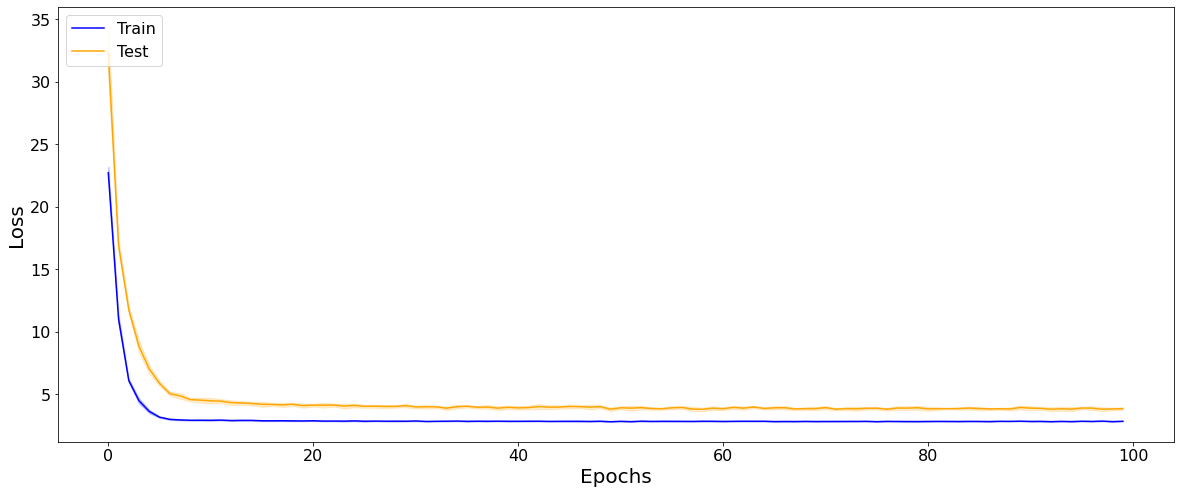

-> 10 experiments executed , Test MSE: Mean = 0.914840579032898, Std = 0.0044616409577429295


In [11]:
epochs = 100
n_exp = 10
n_steps = 1
test_mse = []
for i in range(n_exp):
    history, model, X_test, y_test, X_train, y_train = build_and_fit_model_btc(n_steps, btc_data_ret, epochs=epochs)
    if i==0:
        matrix_train_loss = np.array(history.history['loss'])
        matrix_test_loss =  np.array(history.history['val_loss'])
    else:
        matrix_train_loss = np.vstack([matrix_train_loss, np.array(history.history['loss'])])
        matrix_test_loss = np.vstack([matrix_test_loss, np.array(history.history['val_loss'])])
    test_mse += [history.history['val_mean_squared_error'][-1]]

plt.figure(figsize=(20,8))

# PLOT LOSSES

train_loss = matrix_train_loss.mean(axis = 0)
test_loss = matrix_test_loss.mean(axis = 0)
up_train_loss = train_loss + matrix_train_loss.std(axis = 0)
down_train_loss = train_loss - matrix_train_loss.std(axis = 0)
up_test_loss = test_loss + matrix_test_loss.std(axis = 0)
down_test_loss = test_loss - matrix_test_loss.std(axis = 0)

plt.plot(train_loss, label='Train', color = 'blue')
plt.fill_between(range(epochs), up_train_loss, down_train_loss, color='blue', alpha=.2)

plt.plot(test_loss, label='Test', color = 'orange')
plt.fill_between(range(epochs), up_test_loss, down_test_loss, color='orange', alpha=.2)

plt.legend(fontsize = 16, loc = 'upper left')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.tick_params(axis='both', labelsize= 16 )

plt.show()

print(f'-> {n_exp} experiments executed , Test MSE: Mean = {np.mean(test_mse)}, Std = {np.std(test_mse)}')

Visually compare the prediction performance of the obtained MLP model with the one of the linear regression benchmark model:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


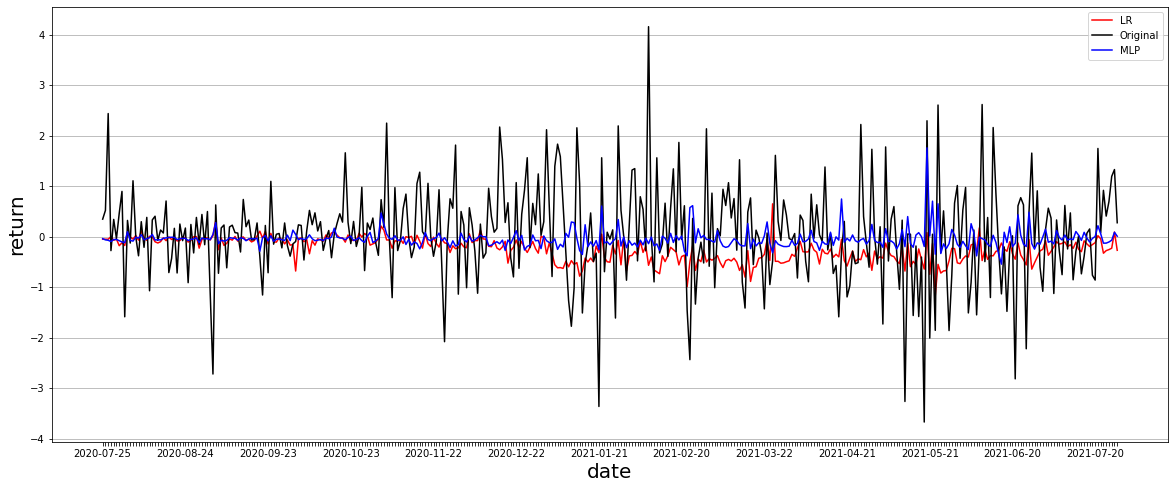

In [8]:
#Comparison between MLP and LR
n_steps=1
history, model, X_test, y_test, X_train, y_train = build_and_fit_model_btc(n_steps, btc_data_ret, epochs=100)
pred = model.predict(np.array(X_test))
original = y_test
predicted = pred
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
n = len(yhat)
dates = btc_data_ret.index[-n:]
fig, ax = plt.subplots(figsize=(20,8))

plt.plot(dates, yhat, color = 'red', label='LR')
plt.plot(dates, original, color='black', label = 'Original')
plt.plot(dates, predicted, color='blue', label = 'MLP')
plt.grid(axis='y')
plt.xlabel('date', fontsize = 20)
plt.ylabel('return', fontsize = 20)
plt.legend(loc='best')

every_nth = 30
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

Analyze feature contribution (Shapley Additive Explanation)

Global average contribution:

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


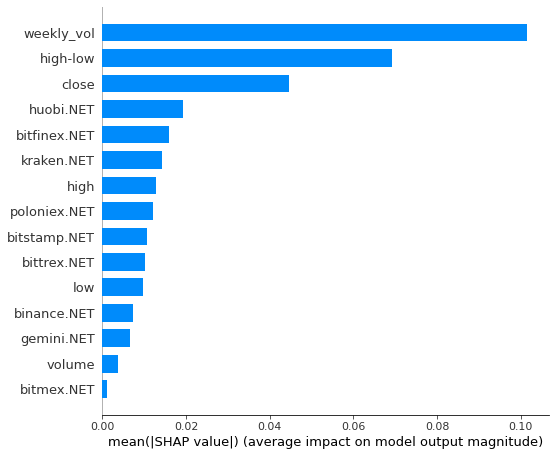

In [9]:
background = X_train
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test, check_additivity=False)
#Global average contribution:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = btc_data.columns)

Local contribution:

In [10]:
shap.initjs()
idx_to_plot = np.random.choice(len(X_test))
print(f'Local feature contribution for {dates[idx_to_plot]}')
#force plot
shap.force_plot(explainer.expected_value[0], shap_values[0][idx_to_plot], features = btc_data.columns)

Local feature contribution for 2021-03-31


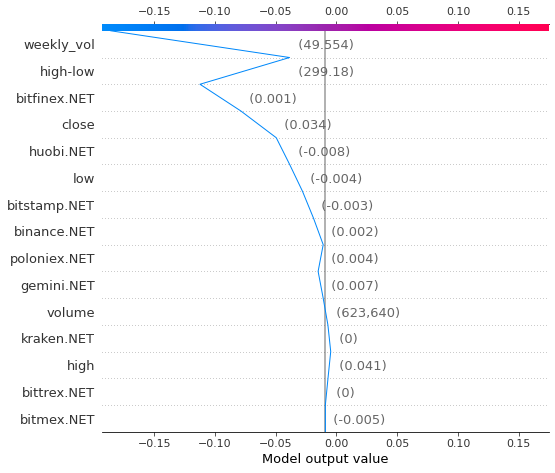

In [11]:
#decision plot
shap.decision_plot(explainer.expected_value[0], shap_values[0][idx_to_plot], features = btc_data.iloc[np.random.choice(len(btc_data_ret)),:], feature_names = btc_data.columns.tolist())

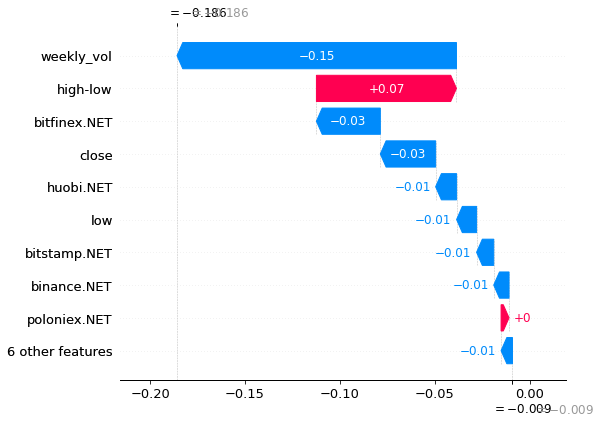

In [12]:
#waterfall plot
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][idx_to_plot], feature_names = btc_data.columns)

## ETH model <a id='sec_ETHreg'></a>

In [13]:
#compute returns 
log_ret = np.log(eth_data['close'].values[1:] / eth_data['close'].values[:-1])
log_ret_high = np.log(eth_data['high'].values[1:] / eth_data['close'].values[:-1])
log_ret_low = np.log(eth_data['low'].values[1:] / eth_data['close'].values[:-1])

eth_data_ret = pd.DataFrame(data=eth_data.values[1:, :], columns = eth_data.columns, index=eth_data.index[1:])
eth_data_ret['close'] = log_ret
eth_data_ret['high'] = log_ret_high
eth_data_ret['low'] = log_ret_low
eth_data_ret.drop('huobi.NET', axis=1, inplace=True)

eth_data_ret

,binance.NET,bitfinex.NET,bitstamp.NET,bittrex.NET,gemini.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume,weekly_vol
date,,,,,,,,,,,,,
2016-07-05,0.000000,-0.006775,0.000000,0.043815,0.006006,-0.010510,-0.011091,-0.085255,0.002633,-0.237303,2.434,961670.0,0.247705
2016-07-06,0.000000,0.020904,0.000000,0.023380,0.006875,0.000916,-0.010402,-0.001916,0.061244,-0.023234,0.900,1020000.0,0.272374
2016-07-07,0.000000,0.004137,0.000000,0.015449,0.009189,0.002469,-0.016655,-0.039106,-0.011572,-0.090346,0.781,1510000.0,0.332138
2016-07-08,0.000000,0.018151,0.000000,-0.000825,0.007478,0.000782,-0.001680,0.116564,0.148867,0.026563,1.340,1200000.0,0.336190
2016-07-09,0.000000,-0.012871,0.000000,0.002330,-0.000480,0.003965,-0.009359,-0.031548,0.006192,-0.052836,0.650,802780.0,0.228340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-24,0.001774,0.036152,0.007728,-0.002043,-0.001087,-0.002090,0.016246,0.028024,0.034413,-0.008552,92.520,147790.0,30.268927
2021-07-25,-0.005864,0.002986,0.003197,-0.007367,0.000181,-0.001144,-0.000327,0.003817,0.005060,-0.035751,87.860,196780.0,25.827133
2021-07-26,0.000977,0.041519,0.011512,-0.008664,0.002028,0.003820,0.016407,0.015524,0.102121,-0.008660,254.850,86170.0,30.587465


Compute the Linear Regression benchmark using 'n_steps' days-lagged data and different normalization techniques (and MSE loss):

In [18]:
for n_steps in range(1, 5):

    ## NO NORMALIZATION ##
    #split dataset
    X_train, X_test, y_train, y_test = split_dataset(eth_data_ret.values, eth_data_ret['close'], n_steps, train_percentage=0.8)

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'No normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MIN-MAX NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(eth_data_ret.values, eth_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=MinMaxScaler(), output_scaler=MinMaxScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Min-Max normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MEAN NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(eth_data_ret.values, eth_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Mean normalization, {} time steps: MSE = {}'.format(n_steps, mse)+'\n')


No normalization, 1 time steps: MSE = 0.003901263419252392
Min-Max normalization, 1 time steps: MSE = 0.005666433021027553
Mean normalization, 1 time steps: MSE = 1.17009081456971

No normalization, 2 time steps: MSE = 0.00391211866313034
Min-Max normalization, 2 time steps: MSE = 0.005682199836083316
Mean normalization, 2 time steps: MSE = 1.1725573026671867

No normalization, 3 time steps: MSE = 0.006420469369223129
Min-Max normalization, 3 time steps: MSE = 0.009325481433505235
Mean normalization, 3 time steps: MSE = 1.9237356738196882

No normalization, 4 time steps: MSE = 0.0064061738935935735
Min-Max normalization, 4 time steps: MSE = 0.009304717893898026
Mean normalization, 4 time steps: MSE = 1.9232552573124646



Hyper-parameter tuning of the MLP model (here we used the same function we previously developed for the BTC case):

In [ ]:
eth_tuning_results = hyper_tuning(eth_data_ret)

After finding that the best results are obtained for 'n_steps'= 1 (i.e. using only 1 day-lagged data), the hyperparameters found thanks to the optimization routine are manually extracted and used to construct the function below:

In [15]:
#create a function to build and train the best MLP found with the tuning procedure

def build_and_fit_model_eth(n_steps, eth_data_ret, epochs=100):
    #split data
    X_train, X_test, y_train, y_test = split_dataset(eth_data_ret.values, eth_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #model definition
    tf.compat.v1.disable_v2_behavior()
    model = k.Sequential()
    initializer = k.initializers.GlorotNormal()
    model.add(layers.Dense(100, input_dim=X_train.shape[1], activity_regularizer=k.regularizers.l1(1), kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = 0.005
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mse',
                metrics=['mean_squared_error']
                )
    #fit model
    history = model.fit(X_train, y_train, 
                        epochs = epochs, 
                        batch_size = 50, 
                        verbose=0,
                        shuffle=False,
                        validation_data=(X_test, y_test))
    return history, model, X_test, y_test, X_train, y_train

Verify the training and test performance by computing 'n_exp' experiments and plotting the corresponding average loss evolution on the train and test set:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in

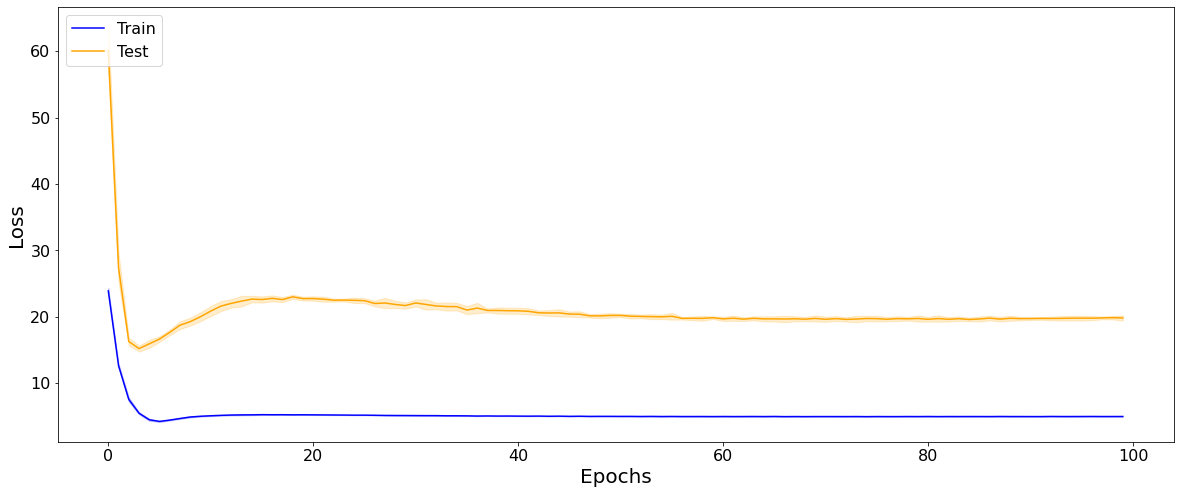

-> 10 experiments executed , Test MSE: Mean = 0.9832976460456848, Std = 0.02517278492450714


In [23]:
epochs = 100
n_exp = 10
n_steps = 1
test_mse = []
for i in range(n_exp):
    history, model, X_test, y_test, X_train, y_train = build_and_fit_model_eth(n_steps, eth_data_ret, epochs=epochs)
    if i==0:
        matrix_train_loss = np.array(history.history['loss'])
        matrix_test_loss =  np.array(history.history['val_loss'])
    else:
        matrix_train_loss = np.vstack([matrix_train_loss, np.array(history.history['loss'])])
        matrix_test_loss = np.vstack([matrix_test_loss, np.array(history.history['val_loss'])])
    test_mse += [history.history['val_mean_squared_error'][-1]]

plt.figure(figsize=(20,8))
# PLOT LOSSES

train_loss = matrix_train_loss.mean(axis = 0)
test_loss = matrix_test_loss.mean(axis = 0)
up_train_loss = train_loss + matrix_train_loss.std(axis = 0)
down_train_loss = train_loss - matrix_train_loss.std(axis = 0)
up_test_loss = test_loss + matrix_test_loss.std(axis = 0)
down_test_loss = test_loss - matrix_test_loss.std(axis = 0)

plt.plot(train_loss, label='Train', color = 'blue')
plt.fill_between(range(epochs), up_train_loss, down_train_loss, color='blue', alpha=.2)

plt.plot(test_loss, label='Test', color = 'orange')
plt.fill_between(range(epochs), up_test_loss, down_test_loss, color='orange', alpha=.2)

plt.legend(fontsize = 16, loc = 'upper left')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.tick_params(axis='both', labelsize= 16 )

plt.show()

print(f'-> {n_exp} experiments executed , Test MSE: Mean = {np.mean(test_mse)}, Std = {np.std(test_mse)}')

Visually compare the prediction performance of the obtained MLP model with the one of the linear regression benchmark model:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


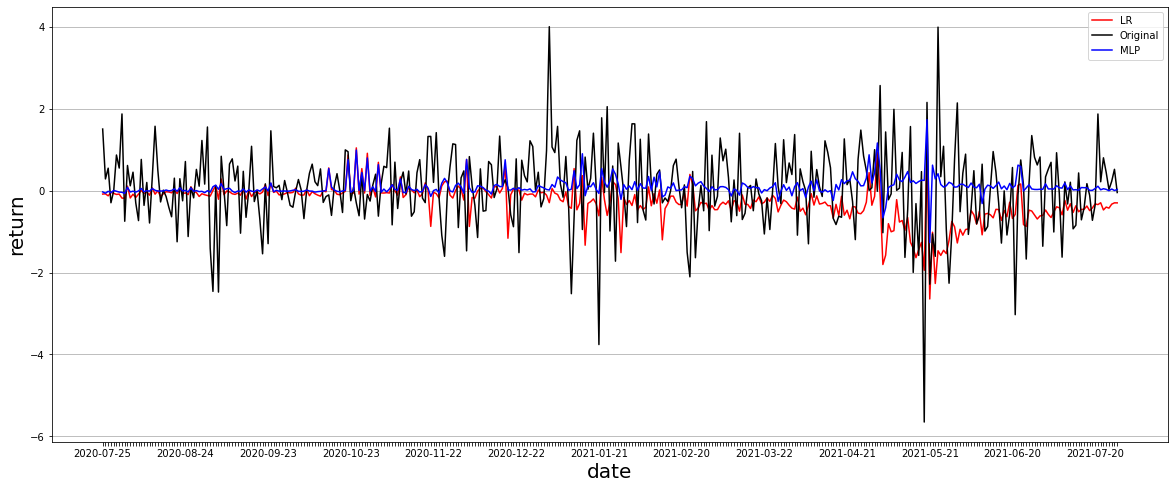

In [17]:
#Comparison between MLP and LR

history, model, X_test, y_test, X_train, y_train = build_and_fit_model_eth(n_steps, eth_data_ret, epochs=100)
pred = model.predict(np.array(X_test))
original = y_test
predicted = pred
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
n = len(yhat)
dates = eth_data_ret.index[-n:]
fig, ax = plt.subplots(figsize=(20,8))

plt.plot(dates, yhat, color = 'red', label='LR')
plt.plot(dates, original, color='black', label = 'Original')
plt.plot(dates, predicted, color='blue', label = 'MLP')
plt.grid(axis='y')
plt.xlabel('date', fontsize = 20)
plt.ylabel('return', fontsize = 20)
plt.legend(loc='best')

every_nth = 30
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

Analyze features contribution (Shapley Additive Features)

Global average contribution:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


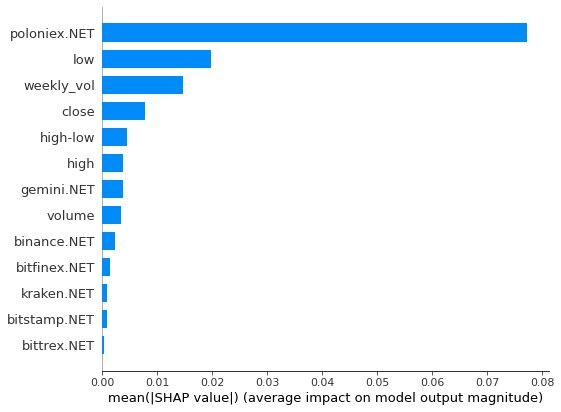

In [18]:
background = X_train
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test, check_additivity=False)
#Global average contribution
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = eth_data_ret.columns)

Local contribution:

In [19]:
shap.initjs()
#force plot
idx_to_plot = np.random.choice(len(X_test))
print(f'Local feature contribution for {dates[idx_to_plot]}')
shap.force_plot(explainer.expected_value[0], shap_values[0][idx_to_plot], features = eth_data_ret.columns)

Local feature contribution for 2021-02-25


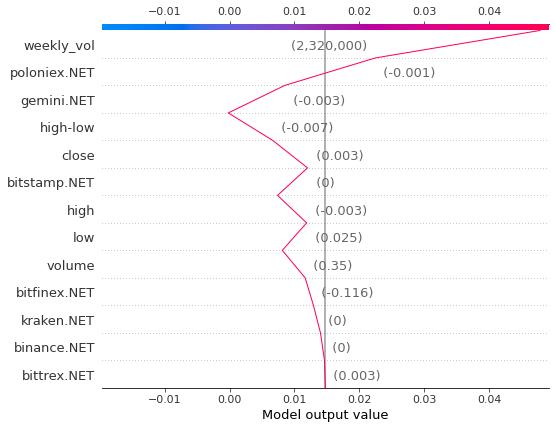

In [20]:
#decision plot
shap.decision_plot(explainer.expected_value[0], shap_values[0][idx_to_plot], features = eth_data.iloc[np.random.choice(len(eth_data_ret)),:], feature_names = eth_data_ret.columns.tolist())

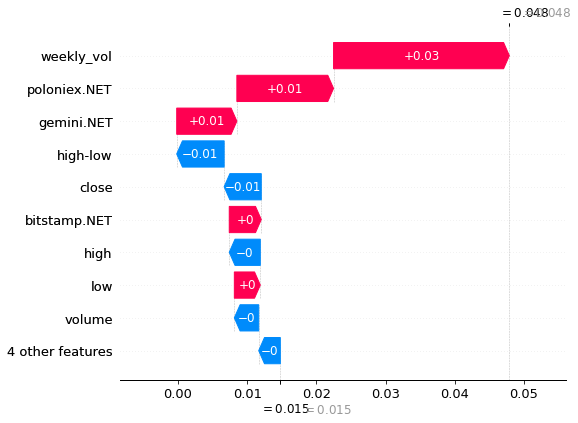

In [21]:
#waterfall plot
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][idx_to_plot], feature_names = eth_data_ret.columns)

# Part III: Classification model <a id='sec_classification'></a>

The goal of this final part is to develop a MLP model to forecast BTC and ETH direction returns: 1 if positive return, 0 otherwise. We define the MLP, tune it, train it and test in comparison to benchmark models for classification (Support Vector Machine and Logistic Regression).

In the following section  [BTC or ETH model](#sec_BTC_ETHclass) we design, tune and test the MLP for BTC or ETH (choose crypto_code below to be BTC or ETH), compare its performance vs benchmark models as SVM and LR in [SVM & LR vs MLP](#sec_SVM_LR_MLP), study the feature contributions through SHAP package [Feature Interpretation](#sec_SHAPclass), and test a trading strategy on test set using the found MLP [Trading Strategy](#sec_trading_strategies).


In [1]:
crypto_code = 'BTC'
#crypto_code = 'ETH'

We again start by importing the needed libraries and the engineered data for both BTC and ETH. The imported data has the same format as in the regression case, it presents the following features:
* 'exchange_name.NET': daily net flows for a given exchange normalised by the corrisponding exchange supply
* 'close': close-close daily return
* 'high': close-high daily return
* 'low': close-low daily return
* 'high-low': high-low spread
* 'volume': daily trading volume
* 'weekly_vol': rolling 5-day volatility estimate (computed from hourly prices)

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime
import talos
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

In [13]:
if crypto_code == 'BTC':
    crypto_data = pd.read_csv(r'data\btc_daily_data_NET_vol.csv')
else:
    crypto_data = pd.read_csv(r'data\eth_daily_data_NET_vol.csv')
    
crypto_data.index = crypto_data['date']
crypto_data = crypto_data.drop(['date', 'Unnamed: 0'], 1)
crypto_data['RET'] = np.log(crypto_data['close']/crypto_data['close'].shift(1)).tolist() # daily log return
crypto_data = crypto_data.iloc[1:, :]

print('Crypto coin selected is {}'.format(crypto_code))
crypto_data.head()

Crypto coin selected is BTC


,binance.NET,bitfinex.NET,bitmex.NET,bitstamp.NET,bittrex.NET,gemini.NET,huobi.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume,weekly_vol,RET
date,,,,,,,,,,,,,,,,
2016-07-05,0.0,-0.011358,-0.046352,-0.005179,-0.000648,-0.001491,0.030021,-0.003803,0.030980,663.67,679.19,657.31,21.88,66150.0,7.634982,-0.017165
2016-07-06,0.0,0.000691,-0.015311,0.005517,0.007162,-0.002760,0.078390,-0.010756,-0.013494,672.70,678.39,662.24,16.15,64870.0,9.708395,0.013514
2016-07-07,0.0,0.013277,-0.115734,-0.007600,-0.002311,-0.038045,-0.025930,0.000635,-0.008824,635.25,676.19,604.95,71.24,118340.0,8.003366,-0.057281
2016-07-08,0.0,0.111602,-0.017591,-0.005359,0.021593,0.008810,0.029312,0.007042,0.002646,662.78,663.43,630.17,33.26,97460.0,8.281091,0.042424
2016-07-09,0.0,-0.040398,0.005818,0.003881,-0.065948,0.015342,0.003079,0.005388,-0.003893,651.83,663.49,620.68,42.81,77480.0,7.964403,-0.016659


Define same function split_dataset as in regression case

In [14]:
def split_dataset(dataset, prices, n_steps, train_percentage=0.8, input_scaler=None, output_scaler=None):
    ## 'dataset' and 'prices' are arrays
    # Splits a multivariate dataset ('dataset') into samples of size 'n_steps', 
    # flattens the resulting input samples and associates the corresponding output from 'prices',
    # divides the dataset in train and test data using 'train_percentage',
    # if 'input_scaler' and 'output_scaler' are not None: 
    # scales the resulting train and test data base on the train data statistics
    
    X, y = list(), list()
    for i in range(len(dataset)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix >= len(dataset):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = dataset[i:end_ix, :], prices[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    X, y = np.array(X), np.array(y)
    # flatten input
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    #divide in train and test data
    n = X.shape[0]
    ix = int(n*train_percentage)
    X_train = X[:ix, :]
    X_test = X[ix+n_steps:, :]
    y_train = y[:ix]
    y_test = y[ix+n_steps:]

    ## scale inputs
    if input_scaler is not None:
        input_scaler.fit(X_train)
        X_train = input_scaler.transform(X_train)
        X_test = input_scaler.transform(X_test)
    ## scale outputs
    if output_scaler is not None:
        # reshape 1d arrays to 2d arrays
        y_train = y_train.reshape(len(y_train), 1)
        y_test = y_test.reshape(len(y_test), 1)
        output_scaler.fit(y_train)
        y_train = output_scaler.transform(y_train)
        y_test = output_scaler.transform(y_test)

    return X_train, X_test, y_train, y_test


## BTC or ETH model for return direction <a id='sec_BTC_ETHclass'></a>

In [15]:
logret = crypto_data['RET']
high_low = crypto_data['high-low']
volumes = crypto_data['volume']
volatility = crypto_data['weekly_vol']
crypto_data.head()

,binance.NET,bitfinex.NET,bitmex.NET,bitstamp.NET,bittrex.NET,gemini.NET,huobi.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume,weekly_vol,RET
date,,,,,,,,,,,,,,,,
2016-07-05,0.0,-0.011358,-0.046352,-0.005179,-0.000648,-0.001491,0.030021,-0.003803,0.030980,663.67,679.19,657.31,21.88,66150.0,7.634982,-0.017165
2016-07-06,0.0,0.000691,-0.015311,0.005517,0.007162,-0.002760,0.078390,-0.010756,-0.013494,672.70,678.39,662.24,16.15,64870.0,9.708395,0.013514
2016-07-07,0.0,0.013277,-0.115734,-0.007600,-0.002311,-0.038045,-0.025930,0.000635,-0.008824,635.25,676.19,604.95,71.24,118340.0,8.003366,-0.057281
2016-07-08,0.0,0.111602,-0.017591,-0.005359,0.021593,0.008810,0.029312,0.007042,0.002646,662.78,663.43,630.17,33.26,97460.0,8.281091,0.042424
2016-07-09,0.0,-0.040398,0.005818,0.003881,-0.065948,0.015342,0.003079,0.005388,-0.003893,651.83,663.49,620.68,42.81,77480.0,7.964403,-0.016659


The following function creates the dataset given the prevDaysVariable selected. These account for the required lagged days to use in the MLP as features

In [16]:
def create_X_y_from_prevDays(prevDaysRet, prevDaysVolat, prevDaysHighLows, prevDaysVolumes, prevDaysExchange, listExchanges):
    maxDays = max(prevDaysRet, prevDaysVolat, prevDaysHighLows, prevDaysVolumes, prevDaysExchange)
    X = np.zeros([logret.shape[0] - maxDays, 
                  prevDaysRet + prevDaysVolat + prevDaysHighLows + prevDaysVolumes + prevDaysExchange*len(listExchanges)])
    column_names = []
    for idxRet in range(prevDaysRet):
        X[:,idxRet] = logret[idxRet:-maxDays+idxRet].T
        column_names.append(crypto_code+'_ret_{}'.format(idxRet+1))
    for idxVolat in range(prevDaysVolat):
        X[:,prevDaysRet + idxVolat] = volatility[idxVolat:-maxDays+idxVolat]
        column_names.append('BTC_Volat_{}'.format(idxVolat+1))
    for idxHighLows in range(prevDaysHighLows):
        X[:,prevDaysRet + prevDaysSR + idxHighLows] = high_low[idxHighLows:-maxDays+idxHighLows]
        column_names.append('BTC_high-low_{}'.format(idxHighLows+1))
    for idxVolumes in range(prevDaysVolumes):
        X[:,prevDaysRet + prevDaysSR + prevDaysHighLows + idxVolumes] = volumes[idxVolumes:-maxDays+idxVolumes]
        column_names.append('BTC_Volum_{}'.format(idxVolumes+1))
        
    N = prevDaysRet + prevDaysVolat + prevDaysHighLows + prevDaysVolumes
    i = 0
    for idxExchanges in range(len(listExchanges)):
        for idxDaysExchange in range(prevDaysExchange):
            aux = crypto_data['{}.NET'.format(listExchanges[idxExchanges])]
            X[:, N + i] = aux[idxDaysExchange:-maxDays+idxDaysExchange]
            column_names.append('{}.NET_{}'.format(listExchanges[idxExchanges], 1+idxDaysExchange))
            i = i+1
    
    y = (logret[maxDays:]>0).astype(int)
    return X, y, column_names

Select exchanges to include in the MLP. For BTC, 9 exchanges are available in total, while for ETH only 7.

In [17]:
if crypto_code == 'BTC':
    exch = ['binance','bitfinex','bitmex','bitstamp','bittrex','gemini','huobi','kraken','poloniex']
    listExchIdx = [0,1,2,3,4,5,6,7,8]

else:
    exch = ['binance', 'bitfinex', 'bitstamp', 'bittrex', 'gemini', 'kraken', 'poloniex']
    listExchIdx = [0,1,2,3,4,5,6]

exchList = []
for idx in listExchIdx:
    exchList.append(exch[idx])
exchList

['binance',
 'bitfinex',
 'bitmex',
 'bitstamp',
 'bittrex',
 'gemini',
 'huobi',
 'kraken',
 'poloniex']

Build the X feature matrix and y output vector, containing flag 1 or 0 for positiv or negative return at that date.

In [18]:
prevDaysRet = 2
prevDaysSR = 2
prevDaysHighLows = 2
prevDaysVolumes = 2
prevDaysExchange = 2
listExchanges = exchList
[X, y, columns_list] = create_X_y_from_prevDays(prevDaysRet, prevDaysSR, prevDaysHighLows, prevDaysVolumes, 
                                                prevDaysExchange, listExchanges)
df_daily = pd.DataFrame(data = np.c_[X, y], columns = columns_list + ['return_flag'])
df_daily_raw = pd.DataFrame(data = X, columns = columns_list)
df_daily

,BTC_ret_1,BTC_ret_2,BTC_Volat_1,BTC_Volat_2,BTC_high-low_1,BTC_high-low_2,BTC_Volum_1,BTC_Volum_2,binance.NET_1,binance.NET_2,...,bittrex.NET_2,gemini.NET_1,gemini.NET_2,huobi.NET_1,huobi.NET_2,kraken.NET_1,kraken.NET_2,poloniex.NET_1,poloniex.NET_2,return_flag
0,-0.017165,0.013514,7.634982,9.708395,21.88,16.15,66150.0,64870.0,0.000000,0.000000,...,0.007162,-0.001491,-0.002760,0.030021,0.078390,-0.003803,-0.010756,0.030980,-0.013494,0.0
1,0.013514,-0.057281,9.708395,8.003366,16.15,71.24,64870.0,118340.0,0.000000,0.000000,...,-0.002311,-0.002760,-0.038045,0.078390,-0.025930,-0.010756,0.000635,-0.013494,-0.008824,1.0
2,-0.057281,0.042424,8.003366,8.281091,71.24,33.26,118340.0,97460.0,0.000000,0.000000,...,0.021593,-0.038045,0.008810,-0.025930,0.029312,0.000635,0.007042,-0.008824,0.002646,0.0
3,0.042424,-0.016659,8.281091,7.964403,33.26,42.81,97460.0,77480.0,0.000000,0.000000,...,-0.065948,0.008810,0.015342,0.029312,0.003079,0.007042,0.005388,0.002646,-0.003893,0.0
4,-0.016659,-0.007267,7.964403,8.127010,42.81,15.18,77480.0,57010.0,0.000000,0.000000,...,0.024960,0.015342,-0.000584,0.003079,-0.012726,0.005388,0.009657,-0.003893,-0.004673,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,0.004966,0.040603,417.882100,377.638761,865.92,1625.31,47050.0,54640.0,0.002881,-0.004138,...,0.000182,0.000333,0.006530,0.001749,-0.001015,-0.004138,0.001514,0.000486,0.001354,1.0
1844,0.040603,0.018983,377.638761,370.044137,1625.31,1090.66,54640.0,63910.0,-0.004138,-0.000504,...,-0.001021,0.006530,0.000317,-0.001015,-0.000964,0.001514,-0.004108,0.001354,0.002328,1.0
1845,0.018983,0.031225,370.044137,344.833062,1090.66,1490.27,63910.0,99270.0,-0.000504,-0.008142,...,-0.001471,0.000317,0.001484,-0.000964,-0.011410,-0.004108,-0.005160,0.002328,0.002814,1.0
1846,0.031225,0.052314,344.833062,453.678573,1490.27,5283.61,99270.0,67380.0,-0.008142,-0.002849,...,-0.012316,0.001484,0.007896,-0.011410,0.009216,-0.005160,-0.002045,0.002814,-0.006142,1.0


The following 3 cells define an MLP and use Talos package to train it to the data with different parameter specifications.

In [22]:
def fit_model(X_train, y_train, X_test, y_test, params):
    # to be able to make several runs on tf
    #tf.compat.v1.disable_v2_behavior() ## optinal -> this is only for collecting the gradient values in the tensorboard
    tf.keras.backend.clear_session()
    # Define model
    model = Sequential()
    #init = RandomUniform(minval=-1, maxval=1)
    init = GlorotNormal()
    activation = 'relu'
    input_dim = X_train.shape[1]
    
    neurons1 = params['first_neuron']
    neurons2 = params['second_neuron']
    neurons3 = params['third_neuron']
    neurons_end = neurons1
    L1_regul = params['L1_regul']
    dropout = params['dropout']
    model.add(Dense(units=neurons1, input_dim=input_dim, activation=activation, kernel_initializer=init, 
                    bias_initializer=init, activity_regularizer=keras.regularizers.l1(L1_regul)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropout))
    if params['number_layers'] > 1:
        model.add(Dense(units=neurons2, input_dim=neurons1, activation=activation, kernel_initializer=init, 
                        bias_initializer=init, activity_regularizer=keras.regularizers.l1(L1_regul)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropout))
        neurons_end = neurons2
    if params['number_layers'] > 2:
        model.add(Dense(units=neurons3, input_dim=neurons2, activation=activation, kernel_initializer=init, 
                        bias_initializer=init, activity_regularizer=keras.regularizers.l1(L1_regul)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropout))
        neurons_end = neurons3
    # output layer = probability
    model.add(Dense(units = 1, input_dim = neurons_end, activation='sigmoid', kernel_initializer=init))
    # define optimiser
    #opt = SGD(learning_rate=0.1, momentum=0.9)
    opt = Adam(learning_rate = params['learning_param'])
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])


    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_grads=True, profile_batch=0)
    #tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=10, profile_batch=0) ## v2 without gradients
    # train the model:
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=params['epochs'], 
                        batch_size=params['batch_size'],
                        verbose=0, ## display progress or not
                        callbacks=[tb]
                       )
    return history, model

In [25]:
## the parameter that you want to be optimized are defined in this dictionary
## This cell can take some hours to run, depending on p dictionary
p = {
    'number_layers' : [3],
    'first_neuron': [8,16],
    'second_neuron': [16, 32],
    'third_neuron':[8],
    'loss_type': ['binary_crossentropy'], 
    'learning_param': [0.001, 0.005],
    'epochs':[100],
    'batch_size':[50],
    'L1_regul': [0],
    'dropout': [0]
}

import talos
input_scaler = StandardScaler()
[X_train, X_test, y_train, y_test] = split_dataset(X, y, 1, 0.8, input_scaler)

scan_object = talos.Scan(x=X_train, y=y_train, params=p, model=fit_model, experiment_name='ml4f', x_val=X_test, y_val=y_test) 


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]


 12%|██████████▌                                                                         | 1/8 [00:06<00:48,  6.89s/it]


 25%|█████████████████████                                                               | 2/8 [00:13<00:41,  6.87s/it]


 38%|███████████████████████████████▌                                                    | 3/8 [00:20<00:34,  6.93s/it]


 50%|██████████████████████████████████████████                                          | 4/8 [00:27<00:27,  6.91s/it]


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:35<00:21,  7.12s/it]


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:42<00:14,  7.17s/it]


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:49<00:07,  7.19s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:56<00:00,  7.12s/it]


In [26]:
scan_object.data

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,L1_regul,batch_size,dropout,epochs,first_neuron,learning_param,loss_type,number_layers,second_neuron,third_neuron
0,01/14/22-104915,01/14/22-104922,6.765516,100,0.587545,0.680433,1.030241,0.452575,0,50,0,100,8,0.001,binary_crossentropy,3,16,8
1,01/14/22-104922,01/14/22-104929,6.742349,100,0.609940,0.653351,0.768990,0.509485,0,50,0,100,8,0.001,binary_crossentropy,3,32,8
2,01/14/22-104929,01/14/22-104936,6.880669,100,0.566960,0.693297,0.882481,0.501355,0,50,0,100,8,0.005,binary_crossentropy,3,16,8
3,01/14/22-104936,01/14/22-104943,6.744656,100,0.542188,0.710223,0.997509,0.566396,0,50,0,100,8,0.005,binary_crossentropy,3,32,8
4,01/14/22-104943,01/14/22-104950,7.365898,100,0.516707,0.729858,1.081053,0.474255,0,50,0,100,16,0.001,binary_crossentropy,3,16,8
5,01/14/22-104951,01/14/22-104958,7.136431,100,0.504371,0.753555,1.103949,0.509485,0,50,0,100,16,0.001,binary_crossentropy,3,32,8
6,01/14/22-104958,01/14/22-105005,7.112414,100,0.488898,0.751523,1.194410,0.517615,0,50,0,100,16,0.005,binary_crossentropy,3,16,8
7,01/14/22-105005,01/14/22-105012,7.175330,100,0.398501,0.814489,1.173801,0.506775,0,50,0,100,16,0.005,binary_crossentropy,3,32,8


Observe from scan_object.data that accuracies might get high in the training set for high neurons in the 1st and 2nd layer, but test set accuracies (val_accuracy) do not get above 56\% in this case.

Let's train one MLP model with specific features and evaluate its performance on average now, below simple 3 layer MLP:

In [32]:
def create_train_model(X, y, input_scaler, neurons1, neurons2, neurons3, epochs = 300, batch_size = 100 ):
    X_train, X_test, y_train, y_test = split_dataset(X, y, 1, 0.8, input_scaler)
    # to be able to make several runs on tf
    tf.compat.v1.disable_v2_behavior() 
    tf.keras.backend.clear_session()
    
    model = Sequential()
    init = GlorotNormal()
    activation = 'LeakyReLU'
    input_dim = X.shape[1]
    
    model.add(Dense(units=neurons1, input_dim=input_dim, activation=activation, kernel_initializer=init, 
                    bias_initializer=init))
    model.add(Dense(units=neurons2, input_dim=neurons1, activation=activation, kernel_initializer=init, 
                    bias_initializer=init))
    model.add(Dense(units=neurons3, input_dim=neurons2, activation=activation, kernel_initializer=init, 
                    bias_initializer=init))
    
    model.add(Dense(units = 1, input_dim = neurons3, activation='sigmoid', kernel_initializer=init))
    # define optimiser
    #opt = SGD(learning_rate=0.01, momentum=0.9)
    opt = Adam(learning_rate = 0.005)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_grads=True, profile_batch=0)
    #tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=10, profile_batch=0) ## v2 without gradients
    # model.summary()
    # train the model:
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=0, ## display progress or not
                        callbacks=[tb]
                       )
    return model, X_train,X_test, y_train, y_test, history

# The next function transforms a decimal number num to a list corresponding of its binary representation, useful to pick among exchanges

def get_binList_from_dec(num):
    dec = []
    for a in range(7):
        d = 6-a
        if num - 2**d >= 0:
            dec.append(1)
            num = num - 2**d
        else:
            dec.append(0)
    return dec

Last model trained accuracy performance over epochs


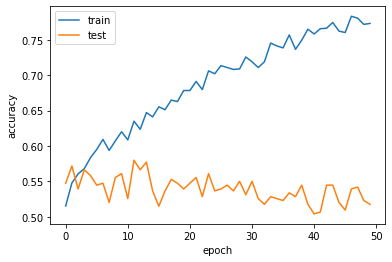

Accuracy on the training data: 80.16%, the testing data: 51.76%
Training data size: , Test data size: ((1477, 26), (369, 26))


In [68]:
# This cell trains the same model several times (total_sims times) and evaluates its loss and accuracy performance.
# Run next cell to plot the results

prevDaysRet = 2
prevDaysSR  = 2
prevDaysHighLows = 2
prevDaysVolumes = 2
prevDaysExchange = 2
[X, y, columns_list] = create_X_y_from_prevDays(prevDaysRet, prevDaysSR, prevDaysHighLows, prevDaysVolumes, 
                                                                    prevDaysExchange, listExchanges)
neurons1 = 16
neurons2 = 16
neurons3 = 16
epochs = 50
batch_size = 50
input_scaler = StandardScaler()

total_sims = 32
j = 0
matrix_train_acc = np.zeros([total_sims, epochs])
matrix_test_acc = np.zeros([total_sims, epochs])
matrix_train_loss = np.zeros([total_sims, epochs])
matrix_test_loss = np.zeros([total_sims, epochs])

while j < total_sims:
    [model, X_train,X_test, y_train, y_test, history] = create_train_model(X, y, input_scaler,
                                                                           neurons1, neurons2, neurons3, 
                                                                          epochs, batch_size)
    
    matrix_train_acc[j,:] = history.history['acc']
    matrix_test_acc[j,:] = history.history['val_acc']
    matrix_train_loss[j,:] = history.history['loss']
    matrix_test_loss[j,:] = history.history['val_loss']
    
    j = j+1

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
print('Last model trained accuracy performance over epochs')
plt.show()
## Display accuracy
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on the training data: %.2f%%, the testing data: %.2f%%' % (100*train_acc, 100*test_acc))
print('Training data size: , Test data size:',  (X_train.shape, X_test.shape))

Mean Train Accuracy = 75.958%, Mean Test Accuracy = 51.778%


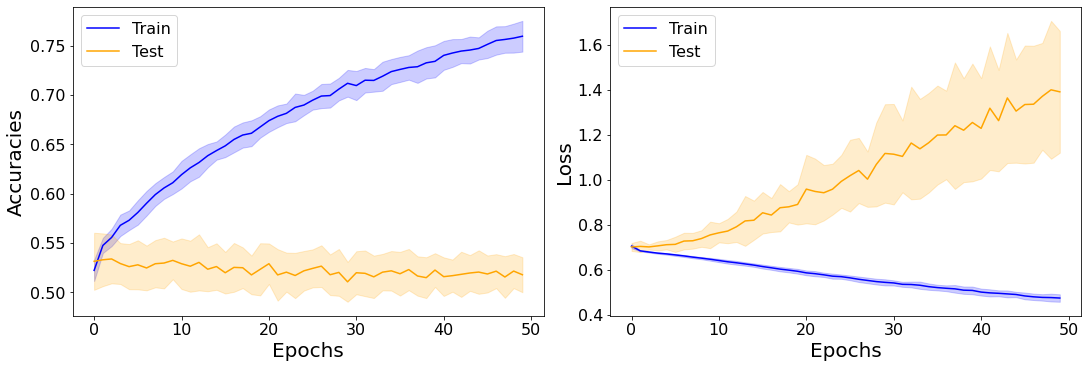

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 5))

# PLOT ACCURACIES AND LOSSES

train_accuracy = matrix_train_acc.mean(axis = 0)
test_accuracy = matrix_test_acc.mean(axis = 0)
up_train_acc = train_accuracy + matrix_train_acc.std(axis = 0)
down_train_acc = train_accuracy - matrix_train_acc.std(axis = 0)
up_test_acc = test_accuracy + matrix_test_acc.std(axis = 0)
down_test_acc = test_accuracy - matrix_test_acc.std(axis = 0)

print('Mean Train Accuracy = {}%, Mean Test Accuracy = {}%'.format(round(train_accuracy[-1]*100, 3), 
                                                                 round(test_accuracy[-1]*100, 3)))
axs[0].plot(train_accuracy, label='Train', color = 'blue')
axs[0].fill_between(range(epochs), up_train_acc, down_train_acc, color='blue', alpha=.2)

axs[0].plot(test_accuracy, label='Test', color = 'orange')
axs[0].fill_between(range(epochs), up_test_acc, down_test_acc, color='orange', alpha=.2)

axs[0].legend(fontsize = 16)
axs[0].set_xlabel('Epochs', fontsize = 20)
axs[0].set_ylabel('Accuracies', fontsize = 20)
axs[0].tick_params(axis='both', labelsize= 16 )


train_loss = matrix_train_loss.mean(axis = 0)
test_loss = matrix_test_loss.mean(axis = 0)
up_train_loss = train_loss + matrix_train_loss.std(axis = 0)
down_train_loss = train_loss - matrix_train_loss.std(axis = 0)
up_test_loss = test_loss + matrix_test_loss.std(axis = 0)
down_test_loss = test_loss - matrix_test_loss.std(axis = 0)

axs[1].plot(train_loss, label='Train', color = 'blue')
axs[1].fill_between(range(epochs), up_train_loss, down_train_loss, color='blue', alpha=.2)

axs[1].plot(test_loss, label='Test', color = 'orange')
axs[1].fill_between(range(epochs), up_test_loss, down_test_loss, color='orange', alpha=.2)

axs[1].legend(fontsize = 16, loc = 'upper left')
axs[1].set_xlabel('Epochs', fontsize = 20)
axs[1].set_ylabel('Loss', fontsize = 20)
axs[1].tick_params(axis='both', labelsize= 16 )

#plt.savefig("NN_"+crypto_code+"_performance.jpg")
plt.show()

Next cell takes a lot of time to run. We investigated which prevDaysFeatures were better to include in the MLP model, by looping over these lagged days for feature parameters.

In [ ]:
############## DO NOT RUN THIS CELL, TAKES AGES ############################################
# This loop can iterate over the lagged days to use in the features
# It takes exponential time to run with prevDaysList size
i = 0
best_params = {} # Save best parameters in the given iteration
prevDaysList = [1,2]
totalExchanges = 0
totalIterations = 2**totalExchanges*len(prevDaysList)**5
for prevDaysRet in prevDaysList:
    for prevDaysSR in prevDaysList:
        for prevDaysHighLows in prevDaysList:
            for prevDaysVolumes in prevDaysList:
                for prevDaysExchange in prevDaysList:
                    # For all given exchanges
                    idxExchanges = 128 # this is [1,1,1,1,1,1,1,1,1], which means we select all exchanges available for ETH
                                       # it would be 512 for BTC to select all exchanges
                    dec = np.array(get_binList_from_dec(idxExchanges))
                    indeces = np.where(np.array(dec) == 1)
                    listExchanges = [exch[index] for index in indeces[0]]
                    # Build required data Matrix X and y
                    [X, y, columns_list] = create_X_y_from_prevDays(prevDaysRet, prevDaysSR, prevDaysHighLows, prevDaysVolumes, 
                                                                    prevDaysExchange, listExchanges)

                    ## the parameter that you want to be optimized are defined in this dictionnary
                    start = time.time()

                    p = {
                        'first_neuron': [8, 16],
                        'second_neuron': [16, 32],
                        'third_neuron':[8],
                        'loss_type': ['binary_crossentropy'], 
                        'learning_param':[0.1],
                        'epochs' : [400],
                        'batch_size': [100]
                    }

                    [X_train, X_test, y_train, y_test] = split_dataset(X, y, 1, 0.8, input_scaler)

                    scan_object = talos.Scan(x=X_train, y=y_train, params=p, model=fit_model, 
                                             experiment_name='ml4f_bigProject', x_val=X_test, y_val=y_test,
                                             disable_progress_bar=True) 
                    end = time.time()

                    df_talos = scan_object.data
                    print(scan_object.data)
                    bestAcc = df_talos[df_talos.acc == df_talos.acc.max()].iloc[0,:].acc
                    bestAcc_test = df_talos[df_talos.val_acc == df_talos.val_acc.max()].iloc[0,:].val_acc
                    iteration = i;
                    best_params['iter_{}'.format(i)] = [iteration, bestAcc, bestAcc_test, listExchanges]
                    i = i+1
                    print('Iteration {} out of {}, last iteration took {} seconds. Best Training Acc = {}%, Best Test Acc = {}%'
                          .format(i, totalIterations, round(end-start, 3), format(100*bestAcc, '.2f'), format(100*bestAcc_test, '.2f')))
                    print('Exchanges = ', listExchanges)

## SVM, Logistic regression vs MLP model <a id='sec_SVM_LR_MLP'></a>

In the following cell we define the SVM and LR classifiers, and compare their performance with the MLP model saved in the variable "model". The performance can be compared in terms of accuracies and in the confusion matrix format below.

In [35]:
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# get the data first
[X, y, columns_list] = create_X_y_from_prevDays(prevDaysRet, prevDaysSR, prevDaysHighLows, prevDaysVolumes, 
                                                                    prevDaysExchange, listExchanges)
input_scaler = StandardScaler()
[X_train, X_test, y_train, y_test] = split_dataset(X, y, 1, 0.8, input_scaler)
print('Crypto Selected = ' + crypto_code)

Crypto Selected = BTC


Results for BTC
SVM RESULT
Training accuracy = 78.7%, Test accuracy = 52.8%:
Precision: 55.4839%, Recall: 82.6923%
LOGISTIC REGRESSION RESULT
Training accuracy = 55.9%, Test accuracy = 53.4%:
Precision: 60.7143%, Recall: 49.0385%
MLP RESULT
Training accuracy = 76.5%, Test accuracy = 54.5%:
Precision: 59.8039%, Recall: 58.6538%


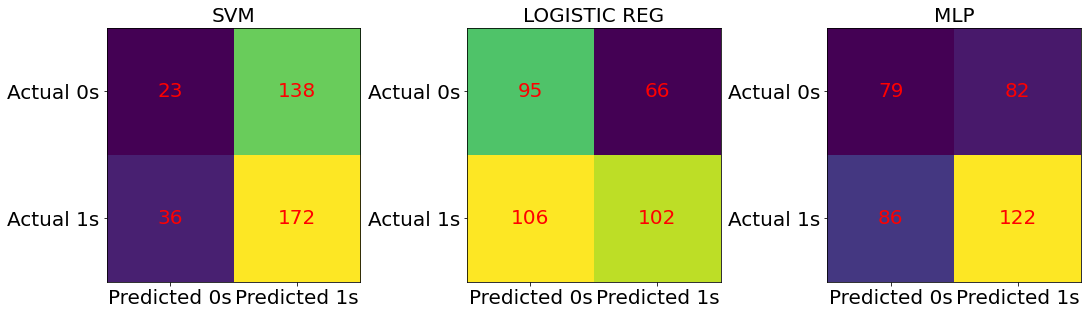

In [37]:
###############   SVM Classifier ######################

#clf = svm.SVC(kernel='linear') # Linear Kernel
clf = svm.SVC(kernel='rbf', gamma = 0.1, C = 1) # Radial basis function Kernel
#clf = svm.SVC(kernel='poly', degree = 10, coef0 = 1 ) # Radial basis function Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred_svm = clf.predict(X_test)
y_train_pred_svm = clf.predict(X_train)
# Model Accuracy: how often is the classifier correct?
print('Results for ' + crypto_code)
print("SVM RESULT")
print("Training accuracy = {}%, Test accuracy = {}%:".format(round(metrics.accuracy_score(y_train, y_train_pred_svm)*100, 1), 
                                                           round(metrics.accuracy_score(y_test, y_pred_svm)*100, 1)))

# Model Precision and Recall: what percentage of positive tuples are labelled as such?
print("Precision: {}%, Recall: {}%".format(round(metrics.precision_score(y_test, y_pred_svm)*100, 4),
                                          round(metrics.recall_score(y_test, y_pred_svm)*100, 4)))

cm = confusion_matrix(y_test, y_pred_svm)

fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15, 5))
fontsize = 20
axs[0].set_title('SVM', fontsize = fontsize)
axs[0].imshow(cm)
axs[0].grid(False)
axs[0].xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axs[0].yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axs[0].set_ylim(1.5, -0.5)
axs[0].tick_params(axis='both', labelsize= fontsize )
for i in range(2):
    for j in range(2):
        axs[0].text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize = fontsize)


###############   Logistic Regression Classifier ######################

model_LR = LogisticRegression(solver='liblinear', random_state=0)
model_LR.fit(X_train, y_train)

y_pred_LR = model_LR.predict(X_test)
y_train_pred_LR = model_LR.predict(X_train)
print("LOGISTIC REGRESSION RESULT")
print("Training accuracy = {}%, Test accuracy = {}%:".format(round(metrics.accuracy_score(y_train, y_train_pred_LR)*100, 1), 
                                                           round(metrics.accuracy_score(y_test, y_pred_LR)*100, 1)))

print("Precision: {}%, Recall: {}%".format(round(metrics.precision_score(y_test, y_pred_LR)*100, 4),
                                          round(metrics.recall_score(y_test, y_pred_LR)*100, 4)))

cm2 = confusion_matrix(y_test, y_pred_LR)

axs[1].set_title('LOGISTIC REG', fontsize = fontsize)
axs[1].imshow(cm2)
axs[1].grid(False)
axs[1].xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axs[1].yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axs[1].set_ylim(1.5, -0.5)
axs[1].tick_params(axis='both', labelsize= fontsize )
for i in range(2):
    for j in range(2):
        axs[1].text(j, i, cm2[i, j], ha='center', va='center', color='red', fontsize = fontsize)


###############   MLP Classifier ######################

y_pred_MLP = model.predict(X_test) >= 0.5
y_train_pred_MLP = model.predict(X_train) >= 0.5
print("MLP RESULT")
print("Training accuracy = {}%, Test accuracy = {}%:".format(round(metrics.accuracy_score(y_train, y_train_pred_MLP)*100, 1), 
                                                           round(metrics.accuracy_score(y_test, y_pred_MLP)*100, 1)))
print("Precision: {}%, Recall: {}%".format(round(metrics.precision_score(y_test, y_pred_MLP)*100, 4),
                                          round(metrics.recall_score(y_test, y_pred_MLP)*100, 4)))

cm_MLP = confusion_matrix(y_test, y_pred_MLP)

axs[2].set_title('MLP', fontsize = fontsize)
axs[2].imshow(cm_MLP)
axs[2].grid(False)
axs[2].xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axs[2].yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axs[2].set_ylim(1.5, -0.5)
axs[2].tick_params(axis='both', labelsize= fontsize )
for i in range(2):
    for j in range(2):
        axs[2].text(j, i, cm_MLP[i, j], ha='center', va='center', color='red', fontsize = fontsize)
#plt.savefig("BTC_confusionMatrices.jpg")
plt.show()

### Return direction prediction: feature interpretation of fitted MLP <a id='sec_SHAPclass'></a>

Crypto selected = BTC


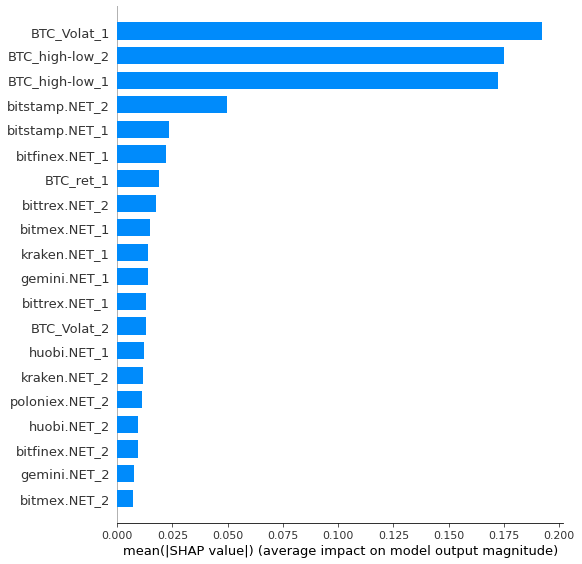

In [39]:
import shap
background = X_train
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test, check_additivity=False)
print('Crypto selected = ' + crypto_code)
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = columns_list)


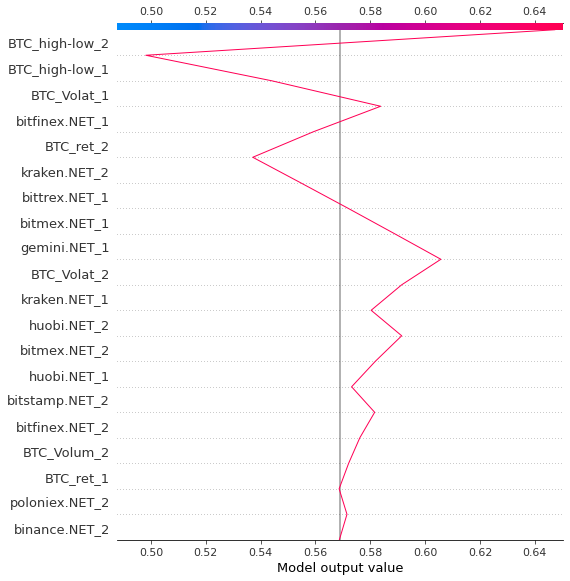

In [41]:
idx_to_plot = 10
shap.decision_plot(explainer.expected_value[0], shap_values[0][idx_to_plot], feature_names = columns_list)

### Confidence in output's accuracy

How does accuracy change with changes in $u \in [0.5, 1]$ and $l \in [0, 0.5]$ confidence levels, such that predicted return is 1 if MLP output is above $u$ and 0 if MLP output is below $l$ ?

In [71]:
u = 0.8
l = 0.2
y_pred_MLP = model.predict(X_test)
findSure0 = np.where(y_pred_MLP < l)
findSure1 = np.where(y_pred_MLP > u)

findSure0 = findSure0[0].tolist()
findSure1 = findSure1[0].tolist()
count0 = 1 - y_test[findSure0].sum()/len(findSure0)
count1 = y_test[findSure1].sum()/len(findSure1)
print('Accuracy for negative returns below {} threshold = {}%, \nAccuracy for positive returns above {} threshold= {}%'.
      format(l, round(count0*100, 2), u, round(count1*100, 2)))


Accuracy for negative returns below 0.2 threshold = 44.37%, 
Accuracy for positive returns above 0.8 threshold= 55.75%


Let's see how accuracy changes in the given MLP model when predicting 0 or 1 changes in the subset of output being below $l$ and above $u$, when predicting 0 and 1 respectively:

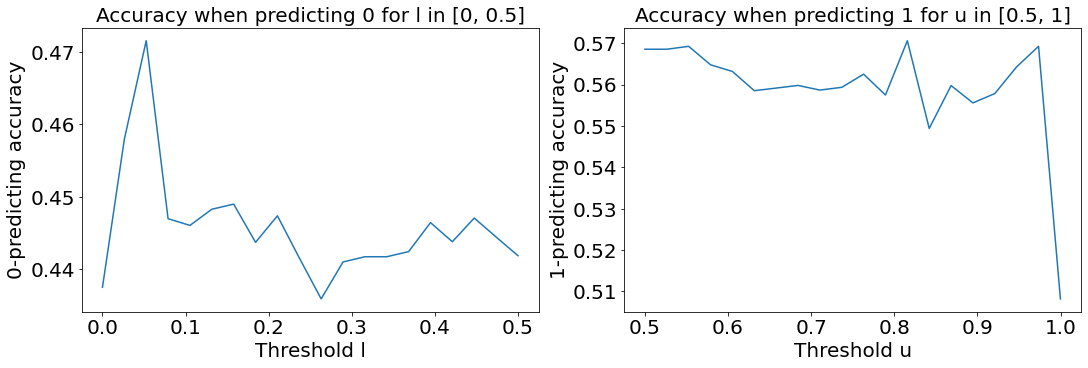

In [72]:
vectL = np.linspace(0.4999, 0.0001, 20)
y_pred_MLP = model.predict(X_test)
vect0_acc = np.zeros([20])
for idx, l in enumerate(vectL):
    findSure0 = np.where(y_pred_MLP < l)
    findSure0 = findSure0[0].tolist()
    vect0_acc[idx] = 1 - y_test[findSure0].sum()/len(findSure0)

    
vectU = np.linspace(0.50001, 0.9999, 20)
vect1_acc = np.zeros([20])
for idx, u in enumerate(vectU):
    findSure1 = np.where(y_pred_MLP > u)
    findSure1 = findSure1[0].tolist()
    vect1_acc[idx] = y_test[findSure1].sum()/len(findSure1)
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 5))
fontsize = 20
axs[0].set_title('Accuracy when predicting 0 for l in [0, 0.5]', fontsize = fontsize)
axs[0].plot(vectL, vect0_acc)
axs[0].set_xlabel('Threshold l', fontsize = fontsize)
axs[0].set_ylabel('0-predicting accuracy', fontsize = fontsize)
axs[0].tick_params(axis='both', labelsize= fontsize )

axs[1].set_title('Accuracy when predicting 1 for u in [0.5, 1]', fontsize = fontsize)
axs[1].plot(vectU, vect1_acc)
axs[1].set_xlabel('Threshold u', fontsize = fontsize)
axs[1].set_ylabel('1-predicting accuracy', fontsize = fontsize)
axs[1].tick_params(axis='both', labelsize= fontsize )

See above that accuracy when predicting 0 do not increase significantly when decreasing $l$, and same for 1 predicting accuracy when $u$ increases. This behavior varies significantly as well with the MLP model obtained.

### Testing trading strategy  <a id='sec_trading_strategies'></a>

We test 3 different trading strategies for the test set period.
* MLP based: Invest all when return is 1 (predicted positive) with confidence level $u$, and invest 0 otherwise.
* Buy \& Hold for the given period
* Random strategy investing with the same frequency than the MLP-based trading strategy

In [74]:
from numpy import random
# Define first the thresholds
u = 0.8
l = 0.2
y_pred_MLP = model.predict(X_test)
findSure0 = np.where(y_pred_MLP < l)
findSure0 = findSure0[0].tolist()
findSure1 = np.where(y_pred_MLP > u)
findSure1 = findSure1[0].tolist()


Nsim = 10000
moneyExp = 0
logretHere = logret[-371:]
moneyExpRandStrat = np.zeros([371, Nsim])
pHere = 0.43 # This can be found from the next cell on average


def computeRandomStratReturn(pHere, Nsim):
    moneyExpRandStrat = np.zeros([1, Nsim])
    for idx, price in enumerate(y_test):
        binDraw = random.binomial(n=1, p = pHere, size = Nsim)
        moneyExpRandStrat = moneyExpRandStrat + binDraw*logretHere[idx]
    finalMoneyRandom = 100*np.exp(moneyExpRandStrat)
    stratRandomReturn = finalMoneyRandom - 100
    return stratRandomReturn

for idx, price in enumerate(y_test):
    if idx in findSure1:
        # invest
        moneyExp = moneyExp + (logretHere[idx])

stratReturn = 100*np.exp(moneyExp) - 100
stratRandomReturn= computeRandomStratReturn(pHere, Nsim)

print('Total return MLP-based strategy on {} in test set = {}%'.format(crypto_code,round(stratReturn, 4)))
print('Total return of a Buy & Hold during same period = {}%'.format(round(np.exp(logretHere.sum())*100 - 100, 4)))
print('Total return of random strategy with investing frequency p = {} is = {}%, Volat = {}%'.format(pHere, round(stratRandomReturn.mean(), 4)
                                                                                , round(stratRandomReturn.std(), 4)))


Total return MLP-based strategy on BTC in test set = 20.0361%
Total return of a Buy & Hold during same period = 319.7232%
Total return of random strategy with investing frequency p = 0.43 is = 94.6386%, Volat = 79.2971%


See that in general the MLP return is bad compared to Buy & Hold and a random strategy, which mainly benefit from the crypto industry uptrend in the recent years. Thus, a good MLP model would need to provide a consistent good performance on the test set after being trained in the training set. This is not the case with the found MLP in this project.

In the cell below we average MLP performance by training total_sims models and testing the mentioned strategy of the average converging MLP.

In [70]:
# Testing same MLP on a given time period
prevDaysRet = 2
prevDaysSR  = 2
prevDaysHighLows = 2
prevDaysVolumes = 2
prevDaysExchange = 2
[X, y, columns_list] = create_X_y_from_prevDays(prevDaysRet, prevDaysSR, prevDaysHighLows, prevDaysVolumes, 
                                                                    prevDaysExchange, listExchanges)
neurons1 = 16
neurons2 = 16
neurons3 = 16
epochs = 200
batch_size = 50
input_scaler = StandardScaler()

# confidence thresholds
u = 0.8
l = 0.2

# Simulation parameters
j = 0
total_sims = 50
vectNNReturns = np.zeros([total_sims, 1])
vectPHere = np.zeros([total_sims, 1])

while j < total_sims:
    [model, X_train,X_test, y_train, y_test, history] = create_train_model(X, y, input_scaler,
                                                                           neurons1, neurons2, neurons3, 
                                                                          epochs, batch_size)
        
    y_pred_MLP = model.predict(X_test)
    findSure0 = np.where(y_pred_MLP < l)
    findSure1 = np.where(y_pred_MLP > u)
    findSure0 = findSure0[0].tolist()
    findSure1 = findSure1[0].tolist()
    moneyExp = 0
    for idx, price in enumerate(y_test):
        if idx in findSure0:
            # do not invest or go short
            #moneyExp = moneyExp - (logretHere[idx])
            1
        elif idx in findSure1:
            # invest
            moneyExp = moneyExp + (logretHere[idx])
    vectNNReturns[j] = 100*np.exp(moneyExp) - 100
    vectPHere[j] = len(findSure1)/len(y_test)
    j = j+1
    print('Iteration {} out of {}'.format(j, total_sims))
print('Mean return of strategy from converged MLP is {}%'.format(round(vectNNReturns.mean(), 2)))
print('Mean investing frequency of strategy from converged MLP is {}'.format(round(vectPHere.mean(), 2)))


Iteration 1 out of 50
Iteration 2 out of 50
Iteration 3 out of 50
Iteration 4 out of 50
Iteration 5 out of 50
Iteration 6 out of 50
Iteration 7 out of 50
Iteration 8 out of 50
Iteration 9 out of 50
Iteration 10 out of 50
Iteration 11 out of 50
Iteration 12 out of 50
Iteration 13 out of 50
Iteration 14 out of 50
Iteration 15 out of 50
Iteration 16 out of 50
Iteration 17 out of 50
Iteration 18 out of 50
Iteration 19 out of 50
Iteration 20 out of 50
Iteration 21 out of 50
Iteration 22 out of 50
Iteration 23 out of 50
Iteration 24 out of 50
Iteration 25 out of 50
Iteration 26 out of 50
Iteration 27 out of 50
Iteration 28 out of 50
Iteration 29 out of 50
Iteration 30 out of 50
Iteration 31 out of 50
Iteration 32 out of 50
Iteration 33 out of 50
Iteration 34 out of 50
Iteration 35 out of 50
Iteration 36 out of 50
Iteration 37 out of 50
Iteration 38 out of 50
Iteration 39 out of 50
Iteration 40 out of 50
Iteration 41 out of 50
Iteration 42 out of 50
Iteration 43 out of 50
Iteration 44 out of 